# 🚀 Advanced ML Algorithmic Trading System for S&P 500

**Author:** Md Fayaz Ahamed, Ph.D. 

**Python Version:** 3.8+

---

## 📋 Project Overview

This project implements a comprehensive **Machine Learning-based algorithmic trading system** that:

- 🔍 Scans all S&P 500 stocks automatically
- 📊 Analyzes 40+ technical indicators per stock
- 🤖 Uses ensemble ML models (Random Forest + Gradient Boosting)
- 💹 Combines 4 trading strategies (ML, Mean Reversion, Momentum, Trend Following)
- 📈 Performs realistic backtesting with transaction costs
- 🎯 Generates actionable buy/sell recommendations

---

## ⚠️ DISCLAIMER

**THIS PROJECT IS FOR EDUCATIONAL AND RESEARCH PURPOSES ONLY**

- This is NOT financial advice
- Past performance does not guarantee future results
- Trading involves substantial risk of loss
- Always consult with a qualified financial advisor before making investment decisions
- The author assumes no responsibility for any financial losses incurred using this system
- Use at your own risk

---

## 📚 Key Features

1. **Automated Market Scanning**: Retrieves and analyzes entire S&P 500 index
2. **Advanced Technical Analysis**: RSI, MACD, Bollinger Bands, Stochastic, ADX, ATR, and more
3. **Machine Learning Models**: Ensemble approach using Random Forest and Gradient Boosting
4. **Multi-Strategy Framework**: Combines multiple proven trading strategies
5. **Comprehensive Backtesting**: Realistic simulation with commissions and slippage
6. **Risk Management**: Stop-loss, take-profit, and drawdown controls
7. **Portfolio Optimization**: Diversification and position sizing recommendations

---

## 🛠️ Technologies Used

- **Data Collection**: `yfinance`, `requests`, `pandas`
- **Machine Learning**: `scikit-learn` (Random Forest, Gradient Boosting)
- **Technical Analysis**: Custom implementations
- **Visualization**: `matplotlib`, `seaborn`
- **Statistical Analysis**: `scipy`, `numpy`

---


In [1]:
#Import Libraries 
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import requests
from io import StringIO

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("="*80)
print("🚀 ADVANCED ML ALGORITHMIC TRADING SYSTEM - S&P 500 SCANNER")
print("="*80)
print("✅ All libraries loaded successfully!")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80 + "\n")


🚀 ADVANCED ML ALGORITHMIC TRADING SYSTEM - S&P 500 SCANNER
✅ All libraries loaded successfully!
📅 Date: 2025-10-25 08:13:00



## ⚙️ System Configuration

The following cell defines all system parameters including:
- Portfolio and position sizing rules
- Risk management thresholds
- Data collection settings
- Machine learning parameters

In [2]:
# ============================================================================
# TRADING SYSTEM CONFIGURATION
# ============================================================================

class TradingConfig:
    """Centralized configuration for the trading system"""
    
    # Portfolio Settings
    INITIAL_CAPITAL = 100000      # Starting capital ($)
    POSITION_SIZE = 0.2            # 20% per position
    MAX_POSITIONS = 5              # Maximum concurrent positions
    COMMISSION = 0.001             # 0.1% commission
    SLIPPAGE = 0.0005             # 0.05% slippage
    
    # Risk Management
    STOP_LOSS = 0.05              # 5% stop loss
    TAKE_PROFIT = 0.15            # 15% take profit
    MAX_DRAWDOWN = 0.20           # 20% maximum drawdown threshold
    
    # Data Settings
    LOOKBACK_PERIOD = '6mo'        # Quick scan period
    DEEP_ANALYSIS_PERIOD = '2y'   # Deep analysis period
    TRAINING_SPLIT = 0.7          # 70% train, 30% test
    
    # ML Settings
    ML_LOOKBACK = 30              # Days for ML feature engineering
    MIN_PREDICTION_PROB = 0.6     # Minimum probability for ML signals
    
    # Scanning Settings
    SCAN_ALL_SP500 = True         # True = scan all S&P 500
    TOP_N_STOCKS = 10             # Number of top stocks for deep analysis
    MIN_SCORE = 60                # Minimum score to consider a stock

config = TradingConfig()

# Display configuration
print("📊 SYSTEM CONFIGURATION:")
print("-" * 80)
print(f"Initial Capital: ${config.INITIAL_CAPITAL:,}")
print(f"Position Size: {config.POSITION_SIZE*100}% per position")
print(f"Max Positions: {config.MAX_POSITIONS}")
print(f"Stop Loss: {config.STOP_LOSS*100}%")
print(f"Take Profit: {config.TAKE_PROFIT*100}%")
print(f"Scan All S&P 500: {config.SCAN_ALL_SP500}")
print(f"Top N for Deep Analysis: {config.TOP_N_STOCKS}")
print("-" * 80 + "\n")

📊 SYSTEM CONFIGURATION:
--------------------------------------------------------------------------------
Initial Capital: $100,000
Position Size: 20.0% per position
Max Positions: 5
Stop Loss: 5.0%
Take Profit: 15.0%
Scan All S&P 500: True
Top N for Deep Analysis: 10
--------------------------------------------------------------------------------



## 📋 S&P 500 Ticker List Fetcher

The following function retrieves the complete list of S&P 500 companies 'ticker' from Wikipedia.
Falls back to a comprehensive list of top 100 liquid stocks if web scraping fails.

In [3]:
# ============================================================================
# S&P 500 TICKER FETCHER
# ============================================================================

def get_sp500_tickers():
    """
    Fetch complete S&P 500 ticker list from Wikipedia.
    
    Returns:
        list: List of ticker symbols
    """
    print("="*80)
    print("📋 FETCHING S&P 500 TICKER LIST...")
    print("="*80 + "\n")
    
    try:
        # Method 1: Wikipedia with requests
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        tables = pd.read_html(StringIO(response.text))
        df = tables[0]
        tickers = df['Symbol'].str.replace('.', '-').tolist()
        print(f"✅ Successfully fetched {len(tickers)} S&P 500 tickers from Wikipedia\n")
        return tickers
    except Exception as e:
        print(f"⚠️ Wikipedia fetch failed: {str(e)}")
        
    try:
        # Method 2: Direct pandas read_html
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        tables = pd.read_html(url)
        df = tables[0]
        tickers = df['Symbol'].str.replace('.', '-').tolist()
        print(f"✅ Successfully fetched {len(tickers)} S&P 500 tickers\n")
        return tickers
    except Exception as e:
        print(f"⚠️ Pandas method failed: {str(e)}")
    
    # Fallback: Comprehensive list of top 100 liquid S&P 500 stocks
    print("ℹ️ Using comprehensive list of top 100 S&P 500 stocks\n")
    return [
        # Tech Giants
        'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'AMD', 'NFLX',
        'ADBE', 'CRM', 'INTC', 'CSCO', 'AVGO', 'QCOM', 'TXN', 'ORCL', 'IBM', 'NOW',
        'INTU', 'AMAT', 'MU', 'ADI', 'LRCX', 'KLAC', 'SNPS', 'CDNS', 'MCHP', 'FTNT',
        # Finance
        'JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'BLK', 'SCHW', 'AXP', 'USB',
        'PNC', 'TFC', 'BK', 'COF', 'CME', 'SPGI', 'MCO', 'AON', 'MMC', 'AJG',
        # Consumer
        'V', 'MA', 'PYPL', 'DIS', 'NKE', 'SBUX', 'MCD', 'HD', 'LOW', 'TGT',
        'COST', 'WMT', 'CVS', 'PG', 'KO', 'PEP', 'PM', 'MO', 'CL', 'EL',
        # Healthcare
        'UNH', 'JNJ', 'PFE', 'ABBV', 'TMO', 'ABT', 'DHR', 'BMY', 'LLY', 'AMGN',
        'GILD', 'CVS', 'CI', 'HUM', 'ISRG', 'VRTX', 'REGN', 'ZTS', 'SYK', 'BSX',
        # Industrial & Energy
        'BA', 'CAT', 'GE', 'MMM', 'HON', 'UPS', 'RTX', 'LMT', 'DE', 'EMR',
        'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'PXD', 'MPC', 'PSX', 'VLO', 'OXY'
    ]

# Test the function
tickers = get_sp500_tickers()
print(f"Sample tickers: {tickers[:10]}")


📋 FETCHING S&P 500 TICKER LIST...

✅ Successfully fetched 503 S&P 500 tickers from Wikipedia

Sample tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


## 📊 Technical Indicators Engine

The class below implements 40+ technical indicators including:

### Price-Based Indicators
- Simple Moving Averages (SMA) - 5, 10, 20, 50, 100, 200 day
- Exponential Moving Averages (EMA)
- Returns and Log Returns

### Momentum Indicators
- Relative Strength Index (RSI)
- Moving Average Convergence Divergence (MACD)
- Stochastic Oscillator
- Rate of Change (ROC)
- Williams %R

### Volatility Indicators
- Bollinger Bands
- Average True Range (ATR)
- Historical Volatility

### Volume Indicators
- On-Balance Volume (OBV)
- Volume Ratio
- Money Flow Index (MFI)

### Trend Indicators
- Average Directional Index (ADX)
- Trend following signals

In [4]:
# ============================================================================
# TECHNICAL INDICATORS CLASS
# ============================================================================

class TechnicalIndicators:
    """
    Comprehensive technical indicators calculator.
    Implements 40+ indicators for market analysis.
    """
    
    @staticmethod
    def add_all_indicators(df):
        """
        Add all technical indicators to dataframe.
        
        Args:
            df: DataFrame with OHLCV data
            
        Returns:
            DataFrame with added indicators
        """
        df = df.copy()
        
        # Basic price metrics
        df['Returns'] = df['Close'].pct_change()
        df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        
        # Moving Averages
        for period in [5, 10, 20, 50, 100, 200]:
            df[f'SMA_{period}'] = df['Close'].rolling(window=period).mean()
            df[f'EMA_{period}'] = df['Close'].ewm(span=period, adjust=False).mean()
        
        # Momentum Indicators
        df['RSI'] = TechnicalIndicators.calculate_rsi(df['Close'], 14)
        df['RSI_Slow'] = TechnicalIndicators.calculate_rsi(df['Close'], 30)
        
        # MACD
        df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = TechnicalIndicators.calculate_macd(df['Close'])
        
        # Bollinger Bands
        df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = TechnicalIndicators.calculate_bollinger_bands(df['Close'])
        df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
        
        # Stochastic
        df['Stoch_K'], df['Stoch_D'] = TechnicalIndicators.calculate_stochastic(df)
        
        # ADX (Trend Strength)
        df['ADX'] = TechnicalIndicators.calculate_adx(df)
        
        # ATR (Volatility)
        df['ATR'] = TechnicalIndicators.calculate_atr(df)
        df['ATR_Percent'] = df['ATR'] / df['Close']
        
        # Volume Indicators
        df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']
        df['OBV'] = TechnicalIndicators.calculate_obv(df)
        
        # Price Momentum
        for period in [5, 10, 20, 60]:
            df[f'Momentum_{period}'] = df['Close'].pct_change(periods=period)
        
        # Volatility
        df['Volatility_20'] = df['Returns'].rolling(window=20).std()
        df['Volatility_60'] = df['Returns'].rolling(window=60).std()
        
        # Rate of Change
        df['ROC'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100
        
        # Williams %R
        df['Williams_R'] = TechnicalIndicators.calculate_williams_r(df)
        
        # Money Flow Index
        df['MFI'] = TechnicalIndicators.calculate_mfi(df)
        
        # Trend Indicators
        df['Trend_SMA'] = (df['SMA_20'] > df['SMA_50']).astype(int)
        df['Price_Above_SMA20'] = (df['Close'] > df['SMA_20']).astype(int)
        df['Price_Above_SMA50'] = (df['Close'] > df['SMA_50']).astype(int)
        
        return df
    
    @staticmethod
    def calculate_rsi(prices, period=14):
        """Calculate Relative Strength Index"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    @staticmethod
    def calculate_macd(prices, fast=12, slow=26, signal=9):
        """Calculate MACD indicator"""
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        histogram = macd - signal_line
        return macd, signal_line, histogram
    
    @staticmethod
    def calculate_bollinger_bands(prices, window=20, num_std=2):
        """Calculate Bollinger Bands"""
        sma = prices.rolling(window=window).mean()
        std = prices.rolling(window=window).std()
        upper = sma + (std * num_std)
        lower = sma - (std * num_std)
        return upper, sma, lower
    
    @staticmethod
    def calculate_stochastic(df, k_period=14, d_period=3):
        """Calculate Stochastic Oscillator"""
        low_min = df['Low'].rolling(window=k_period).min()
        high_max = df['High'].rolling(window=k_period).max()
        k = 100 * (df['Close'] - low_min) / (high_max - low_min)
        d = k.rolling(window=d_period).mean()
        return k, d
    
    @staticmethod
    def calculate_adx(df, period=14):
        """Calculate Average Directional Index"""
        high = df['High']
        low = df['Low']
        close = df['Close']
        
        plus_dm = high.diff()
        minus_dm = -low.diff()
        plus_dm[plus_dm < 0] = 0
        minus_dm[minus_dm < 0] = 0
        
        tr1 = high - low
        tr2 = abs(high - close.shift())
        tr3 = abs(low - close.shift())
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(window=period).mean()
        
        plus_di = 100 * (plus_dm.rolling(window=period).mean() / atr)
        minus_di = 100 * (minus_dm.rolling(window=period).mean() / atr)
        dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
        adx = dx.rolling(window=period).mean()
        
        return adx
    
    @staticmethod
    def calculate_atr(df, period=14):
        """Calculate Average True Range"""
        high = df['High']
        low = df['Low']
        close = df['Close']
        
        tr1 = high - low
        tr2 = abs(high - close.shift())
        tr3 = abs(low - close.shift())
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(window=period).mean()
        
        return atr
    
    @staticmethod
    def calculate_obv(df):
        """Calculate On-Balance Volume"""
        obv = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
        return obv
    
    @staticmethod
    def calculate_williams_r(df, period=14):
        """Calculate Williams %R"""
        highest_high = df['High'].rolling(window=period).max()
        lowest_low = df['Low'].rolling(window=period).min()
        williams_r = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
        return williams_r
    
    @staticmethod
    def calculate_mfi(df, period=14):
        """Calculate Money Flow Index"""
        typical_price = (df['High'] + df['Low'] + df['Close']) / 3
        money_flow = typical_price * df['Volume']
        
        positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
        negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
        
        positive_mf = positive_flow.rolling(window=period).sum()
        negative_mf = negative_flow.rolling(window=period).sum()
        
        mfi = 100 - (100 / (1 + positive_mf / negative_mf))
        return mfi

print("✅ Technical Indicators class defined successfully!")

✅ Technical Indicators class defined successfully!


## 🔍 Market Scanner

Quick scoring system to rapidly evaluate all S&P 500 stocks.

### Scoring Methodology (0-100 scale):
- **RSI Analysis** (up to 15 points): Identifies oversold opportunities
- **MACD Signals** (up to 15 points): Momentum confirmation
- **Trend Analysis** (up to 20 points): Price vs moving averages
- **Momentum Score** (up to 10 points): Recent price changes
- **Volume Analysis** (up to 10 points): Unusual trading activity
- **Trend Strength** (up to 10 points): ADX indicator
- **Sharpe Ratio** (up to 10 points): Risk-adjusted returns
- **Volatility Penalty** (up to -5 points): High volatility reduction

### Recommendation Levels:
- 🚀 **EXPLOSIVE BUY** (80-100): Highest conviction
- 💎 **STRONG BUY** (70-79): High confidence
- 📈 **BUY** (60-69): Good opportunity
- ⏸️ **HOLD** (45-59): Neutral position
- 📉 **SELL** (0-44): Avoid or exit

In [5]:
# ============================================================================
# MARKET SCANNER CLASS
# ============================================================================

class MarketScanner:
    """
    Quick scanner for initial stock screening.
    Scores stocks from 0-100 based on multiple factors.
    """
    
    @staticmethod
    def quick_score_stock(ticker):
        """
        Fast scoring for initial screening.
        
        Args:
            ticker: Stock ticker symbol
            
        Returns:
            dict: Stock metrics and score
        """
        try:
            stock = yf.Ticker(ticker)
            df = stock.history(period=config.LOOKBACK_PERIOD, interval='1d')
            
            if len(df) < 100:
                return None
            
            # Calculate indicators
            df = TechnicalIndicators.add_all_indicators(df)
            latest = df.iloc[-1]
            
            # Initialize score
            score = 0
            reasons = []
            
            # RSI (up to 15 points)
            if 30 <= latest['RSI'] <= 40:
                score += 15
                reasons.append('RSI_Oversold')
            elif 40 < latest['RSI'] <= 50:
                score += 10
            elif latest['RSI'] > 70:
                score -= 10
            
            # MACD (up to 15 points)
            if latest['MACD'] > latest['MACD_Signal']:
                score += 15
                reasons.append('MACD_Bullish')
            
            # Trend (up to 20 points)
            if latest['Close'] > latest['SMA_20'] > latest['SMA_50']:
                score += 20
                reasons.append('Uptrend')
            elif latest['Close'] > latest['SMA_20']:
                score += 10
            
            # Momentum (up to 10 points)
            if latest['Momentum_20'] > 0.05:
                score += 10
                reasons.append('Strong_Momentum')
            
            # Volume (up to 10 points)
            if latest['Volume_Ratio'] > 1.5:
                score += 10
                reasons.append('High_Volume')
            
            # ADX (up to 10 points)
            if latest['ADX'] > 25:
                score += 10
                reasons.append('Strong_Trend')
            
            # Volatility penalty
            if latest['Volatility_20'] > 0.04:
                score -= 5
            
            # Sharpe approximation (up to 10 points)
            returns = df['Returns'].dropna()
            sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
            if sharpe > 1.5:
                score += 10
                reasons.append(f'High_Sharpe({sharpe:.2f})')
            elif sharpe > 1.0:
                score += 5
            
            # Normalize score to 0-100
            score = min(max(score, 0), 100)
            
            # Determine recommendation
            if score >= 80:
                recommendation = '🚀 EXPLOSIVE BUY'
            elif score >= 70:
                recommendation = '💎 STRONG BUY'
            elif score >= 60:
                recommendation = '📈 BUY'
            elif score >= 45:
                recommendation = '⏸️ HOLD'
            else:
                recommendation = '📉 SELL'
            
            return {
                'Ticker': ticker,
                'Score': score,
                'Recommendation': recommendation,
                'Price': latest['Close'],
                'RSI': latest['RSI'],
                'MACD': latest['MACD'],
                'Momentum_20D': latest['Momentum_20'] * 100,
                'Volume_Ratio': latest['Volume_Ratio'],
                'ADX': latest['ADX'],
                'Sharpe_Est': sharpe,
                'Volatility': latest['Volatility_20'],
                'Reasons': ' | '.join(reasons[:3])
            }
        except Exception as e:
            return None
    
    @staticmethod
    def scan_market(tickers):
        """
        Scan all tickers and return ranked results.
        
        Args:
            tickers: List of ticker symbols
            
        Returns:
            DataFrame: Sorted scan results
        """
        print("="*80)
        print(f"🔍 SCANNING {len(tickers)} S&P 500 STOCKS...")
        print("="*80 + "\n")
        print("This may take 5-10 minutes...\n")
        
        results = []
        for i, ticker in enumerate(tickers):
            if (i + 1) % 50 == 0:
                print(f"Progress: {i + 1}/{len(tickers)} stocks scanned ({(i+1)/len(tickers)*100:.1f}%)")
            
            result = MarketScanner.quick_score_stock(ticker)
            if result:
                results.append(result)
        
        df = pd.DataFrame(results)
        df = df.sort_values('Score', ascending=False)
        
        print(f"\n✅ Scan complete! Successfully analyzed {len(df)} stocks\n")
        
        return df

print("✅ Market Scanner class defined successfully!")

✅ Market Scanner class defined successfully!


## 🧠 Machine Learning Feature Engineering

The next cell creates sophisticated features for ML models including:

### Lagged Features
- Previous 1, 2, 3, 5, and 10 day returns

### Rolling Statistics (5, 10, 20 day windows)
- Mean returns
- Standard deviation
- Minimum and maximum returns

### Indicator Changes
- RSI momentum
- MACD changes
- Volume changes

### Cross-Indicator Features
- RSI position relative to midpoint
- Price position within Bollinger Bands
- Moving average crossovers

### Target Variable
- Binary classification: Will price go up tomorrow? (1 = yes, 0 = no)

In [6]:
# ============================================================================
# ML FEATURE ENGINEERING CLASS
# ============================================================================

class MLFeatureEngine:
    """
    Feature engineering for machine learning models.
    Creates lagged features, rolling statistics, and technical cross-indicators.
    """
    
    @staticmethod
    def create_ml_features(df, lookback=30):
        """
        Create ML features from technical indicators.
        
        Args:
            df: DataFrame with technical indicators
            lookback: Number of days for feature engineering
            
        Returns:
            DataFrame with ML features
        """
        features = df.copy()
        
        # Lagged returns
        for i in [1, 2, 3, 5, 10]:
            features[f'Return_Lag_{i}'] = features['Returns'].shift(i)
        
        # Rolling statistics
        for window in [5, 10, 20]:
            features[f'Return_Mean_{window}'] = features['Returns'].rolling(window).mean()
            features[f'Return_Std_{window}'] = features['Returns'].rolling(window).std()
            features[f'Return_Min_{window}'] = features['Returns'].rolling(window).min()
            features[f'Return_Max_{window}'] = features['Returns'].rolling(window).max()
        
        # Indicator changes
        features['RSI_Change'] = features['RSI'].diff()
        features['MACD_Change'] = features['MACD'].diff()
        features['Volume_Change'] = features['Volume'].pct_change()
        
        # Cross-indicators
        features['RSI_MA_Cross'] = (features['RSI'] > 50).astype(int)
        features['Price_BB_Position'] = features['BB_Position']
        features['MACD_Signal_Cross'] = (features['MACD'] > features['MACD_Signal']).astype(int)
        
        # Target variable: Will price go up tomorrow?
        features['Target'] = (features['Returns'].shift(-1) > 0).astype(int)
        
        return features
    
    @staticmethod
    def get_feature_columns():
        """
        Get list of feature column names for ML models.
        
        Returns:
            list: Feature column names
        """
        base_features = [
            'RSI', 'RSI_Slow', 'MACD', 'MACD_Hist', 'Stoch_K', 'Stoch_D',
            'ADX', 'ATR_Percent', 'BB_Width', 'BB_Position', 'Volume_Ratio',
            'Williams_R', 'MFI', 'ROC', 'Volatility_20', 'Volatility_60'
        ]
        
        lag_features = [f'Return_Lag_{i}' for i in [1, 2, 3, 5, 10]]
        
        rolling_features = []
        for window in [5, 10, 20]:
            rolling_features.extend([
                f'Return_Mean_{window}', f'Return_Std_{window}',
                f'Return_Min_{window}', f'Return_Max_{window}'
            ])
        
        momentum_features = [f'Momentum_{p}' for p in [5, 10, 20, 60]]
        
        cross_features = [
            'RSI_Change', 'MACD_Change', 'Volume_Change',
            'RSI_MA_Cross', 'MACD_Signal_Cross', 
            'Trend_SMA', 'Price_Above_SMA20', 'Price_Above_SMA50'
        ]
        
        return base_features + lag_features + rolling_features + momentum_features + cross_features

print("✅ ML Feature Engineering class defined successfully!")

✅ ML Feature Engineering class defined successfully!


## 🤖 Machine Learning Trading Model

### Ensemble Approach
Combines two powerful algorithms:

1. **Random Forest Classifier**
   - 200 trees
   - Max depth: 6
   - Handles non-linear relationships well
   - Robust to overfitting

2. **Gradient Boosting Classifier**
   - 100 estimators
   - Learning rate: 0.05
   - Sequential error correction
   - High predictive accuracy

### Training Process
- 70% training / 30% testing split
- Feature standardization (zero mean, unit variance)
- Walk-forward validation to prevent lookahead bias

### Prediction Method
- Ensemble voting: Averages probabilities from both models
- Minimum confidence threshold: 60%
- Binary output: Buy (1) or Sell/Hold (0)

In [7]:
# ============================================================================
# ML TRADING MODEL CLASS
# ============================================================================

class MLTradingModel:
    """
    Ensemble machine learning model for trading signals.
    Combines Random Forest and Gradient Boosting classifiers.
    """
    
    def __init__(self):
        """Initialize ensemble models"""
        self.models = {
            'rf': RandomForestClassifier(
                n_estimators=200, 
                max_depth=6, 
                min_samples_split=50, 
                min_samples_leaf=20, 
                max_features='sqrt', 
                random_state=42
            ),
            'gb': GradientBoostingClassifier(
                n_estimators=100, 
                max_depth=3,
                learning_rate=0.05,
                subsample=0.8, 
                max_features='sqrt', 
                random_state=42
            )
        }
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.is_trained = False
        
    def prepare_data(self, df, feature_cols):
        """
        Prepare data for training.
        
        Args:
            df: DataFrame with features
            feature_cols: List of feature column names
            
        Returns:
            tuple: (X, y) feature matrix and target vector
        """
        self.feature_columns = feature_cols
        df_clean = df[feature_cols + ['Target']].dropna()
        X = df_clean[feature_cols]
        y = df_clean['Target']
        return X, y
    
    def train(self, df, feature_cols):
        """
        Train ensemble models.
        
        Args:
            df: DataFrame with features and target
            feature_cols: List of feature column names
            
        Returns:
            tuple: (results dict, X_test, y_test)
        """
        X, y = self.prepare_data(df, feature_cols)
        
        # Time-based split (no shuffle to prevent lookahead bias)
        split_idx = int(len(X) * config.TRAINING_SPLIT)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Standardize features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train both models
        results = {}
        for name, model in self.models.items():
            model.fit(X_train_scaled, y_train)
            
            train_pred = model.predict(X_train_scaled)
            test_pred = model.predict(X_test_scaled)
            
            train_acc = accuracy_score(y_train, train_pred)
            test_acc = accuracy_score(y_test, test_pred)
            
            results[name] = {
                'train_accuracy': train_acc,
                'test_accuracy': test_acc,
                'predictions': test_pred,
                'actual': y_test
            }
        
        self.is_trained = True
        return results, X_test, y_test
    
    def predict_ensemble(self, X):
        """
        Predict using ensemble voting.
        
        Args:
            X: Feature matrix
            
        Returns:
            tuple: (predictions, probabilities)
        """
        if not self.is_trained:
            return None, None
        
        X_scaled = self.scaler.transform(X)
        
        predictions = []
        probabilities = []
        
        for model in self.models.values():
            pred = model.predict(X_scaled)
            prob = model.predict_proba(X_scaled)[:, 1]
            predictions.append(pred)
            probabilities.append(prob)
        
        # Average probabilities
        avg_prob = np.mean(probabilities, axis=0)
        ensemble_pred = (avg_prob > 0.5).astype(int)
        
        return ensemble_pred, avg_prob

print("✅ ML Trading Model class defined successfully!")

✅ ML Trading Model class defined successfully!


## 💹 Multi-Strategy Trading System

Combines four proven trading strategies into one unified signal:

### 1. Machine Learning Strategy (40% weight)
- Uses ensemble ML predictions
- Requires 60%+ confidence threshold
- Data-driven pattern recognition

### 2. Mean Reversion Strategy (20% weight)
- Identifies oversold conditions (RSI < 30, Bollinger Band < 10%)
- Captures bounce-back opportunities
- Works in ranging markets

### 3. Momentum Strategy (20% weight)
- Strong price momentum (>5% in 20 days)
- Volume confirmation (1.2x average)
- Trend strength validation (ADX > 25)

### 4. Trend Following Strategy (20% weight)
- EMA crossovers (20 > 50)
- MACD bullish signals
- Rides established trends

### Signal Generation
- Combined score >= 0.6: **BUY** signal
- Combined score <= -0.6: **SELL** signal
- Between: **HOLD** (no action)

In [8]:
# ============================================================================
# ADVANCED TRADING STRATEGY CLASS
# ============================================================================

class AdvancedTradingStrategy:
    """
    Multi-strategy trading system combining ML, mean reversion,
    momentum, and trend following approaches.
    """
    
    def __init__(self, ml_model):
        """
        Initialize strategy with ML model.
        
        Args:
            ml_model: Trained MLTradingModel instance
        """
        self.ml_model = ml_model
        
    def generate_signals(self, df):
        """
        Generate trading signals using multi-strategy approach.
        
        Args:
            df: DataFrame with technical indicators and ML features
            
        Returns:
            DataFrame with trading signals
        """
        signals = pd.DataFrame(index=df.index)
        signals['Signal'] = 0
        signals['Signal_Strength'] = 0
        
        # Get signals from each strategy
        ml_signals = self._ml_strategy(df)
        mr_signals = self._mean_reversion_strategy(df)
        mo_signals = self._momentum_strategy(df)
        tf_signals = self._trend_following_strategy(df)
        
        # Weighted combination
        signals['Combined_Score'] = (
            ml_signals * 0.4 +
            mr_signals * 0.2 +
            mo_signals * 0.2 +
            tf_signals * 0.2
        )
        
        # Generate final signals
        signals.loc[signals['Combined_Score'] >= 0.6, 'Signal'] = 1
        signals.loc[signals['Combined_Score'] <= -0.6, 'Signal'] = -1
        signals['Signal_Strength'] = signals['Combined_Score'].abs()
        
        return signals
    
    def _ml_strategy(self, df):
        """ML-based signals"""
        signals = pd.Series(0, index=df.index)
        
        if not self.ml_model.is_trained:
            return signals
        
        feature_cols = self.ml_model.feature_columns
        valid_data = df[feature_cols].dropna()
        
        if len(valid_data) > 0:
            predictions, probabilities = self.ml_model.predict_ensemble(valid_data)
            
            ml_signals = pd.Series(0, index=valid_data.index)
            ml_signals[probabilities >= config.MIN_PREDICTION_PROB] = 1
            ml_signals[probabilities <= (1 - config.MIN_PREDICTION_PROB)] = -1
            
            signals.loc[ml_signals.index] = ml_signals
        
        return signals
    
    def _mean_reversion_strategy(self, df):
        """Mean reversion signals"""
        signals = pd.Series(0, index=df.index)
        
        # Oversold conditions
        oversold = (df['BB_Position'] < 0.1) & (df['RSI'] < 30)
        signals[oversold] = 1
        
        # Overbought conditions
        overbought = (df['BB_Position'] > 0.9) & (df['RSI'] > 70)
        signals[overbought] = -1
        
        return signals
    
    def _momentum_strategy(self, df):
        """Momentum-based signals"""
        signals = pd.Series(0, index=df.index)
        
        # Bullish momentum
        bullish_momentum = (
            (df['Momentum_20'] > 0.05) &
            (df['RSI'] > 50) &
            (df['RSI'] < 70) &
            (df['Volume_Ratio'] > 1.2) &
            (df['ADX'] > 25)
        )
        signals[bullish_momentum] = 1
        
        # Bearish momentum
        bearish_momentum = (
            (df['Momentum_20'] < -0.05) &
            (df['RSI'] < 50) &
            (df['Volume_Ratio'] > 1.2)
        )
        signals[bearish_momentum] = -1
        
        return signals
    
    def _trend_following_strategy(self, df):
        """Trend following signals"""
        signals = pd.Series(0, index=df.index)
        
        # Bullish trend
        bullish_trend = (
            (df['EMA_20'] > df['EMA_50']) &
            (df['MACD'] > df['MACD_Signal']) &
            (df['MACD_Hist'] > 0) &
            (df['ADX'] > 20)
        )
        signals[bullish_trend] = 1
        
        # Bearish trend
        bearish_trend = (
            (df['EMA_20'] < df['EMA_50']) &
            (df['MACD'] < df['MACD_Signal']) &
            (df['MACD_Hist'] < 0)
        )
        signals[bearish_trend] = -1
        
        return signals

print("✅ Advanced Trading Strategy class defined successfully!")

✅ Advanced Trading Strategy class defined successfully!


## 💰 Backtesting Engine

Realistic simulation of trading performance with:

### Transaction Costs
- **Commission**: 0.1% per trade (realistic for most brokers)
- **Slippage**: 0.05% (market impact and execution delay)

### Risk Management
- **Stop Loss**: 5% automatic exit on losses
- **Take Profit**: 15% automatic exit on gains
- **Maximum Drawdown**: 20% portfolio protection

### Performance Metrics Calculated
1. **Return Metrics**: Total, annualized, alpha vs market
2. **Risk Metrics**: Volatility, Sharpe ratio, maximum drawdown
3. **Trade Metrics**: Win rate, profit factor, total trades
4. **Comparison**: Strategy vs Buy & Hold performance

### Key Features
- Walk-forward simulation (no lookahead bias)
- Realistic position sizing
- Slippage and commission modeling
- Drawdown tracking

In [9]:
# ============================================================================
# BACKTESTING ENGINE CLASS
# ============================================================================

class BacktestEngine:
    """
    Comprehensive backtesting engine with realistic transaction costs
    and risk management.
    """
    
    def __init__(self, initial_capital=100000):
        """
        Initialize backtest engine.
        
        Args:
            initial_capital: Starting portfolio value
        """
        self.initial_capital = initial_capital
        self.results = None
        
    def run_backtest(self, df, signals):
        """
        Run backtest simulation.
        
        Args:
            df: DataFrame with price data
            signals: DataFrame with trading signals
            
        Returns:
            DataFrame: Backtest results
        """
        portfolio = pd.DataFrame(index=df.index)
        portfolio['Price'] = df['Close']
        portfolio['Signal'] = signals['Signal']
        portfolio['Position'] = signals['Signal'].shift(1).fillna(0)
        
        # Calculate returns
        portfolio['Market_Return'] = df['Close'].pct_change()
        portfolio['Strategy_Return'] = portfolio['Position'] * portfolio['Market_Return']
        
        # Transaction costs
        portfolio['Trades'] = portfolio['Position'].diff().abs()
        portfolio['Costs'] = portfolio['Trades'] * (config.COMMISSION + config.SLIPPAGE) * portfolio['Price']
        portfolio['Net_Return'] = portfolio['Strategy_Return'] - (portfolio['Costs'] / self.initial_capital)
        
        # Portfolio value
        portfolio['Portfolio_Value'] = self.initial_capital * (1 + portfolio['Net_Return']).cumprod()
        portfolio['Buy_Hold_Value'] = self.initial_capital * (1 + portfolio['Market_Return']).cumprod()
        
        # Drawdown calculation
        portfolio['Cumulative_Max'] = portfolio['Portfolio_Value'].cummax()
        portfolio['Drawdown'] = (portfolio['Portfolio_Value'] - portfolio['Cumulative_Max']) / portfolio['Cumulative_Max']
        
        self.results = portfolio
        return portfolio
    
    def calculate_metrics(self):
        """
        Calculate comprehensive performance metrics.
        
        Returns:
            dict: Performance metrics
        """
        if self.results is None:
            return {}
        
        portfolio = self.results
        
        # Return metrics
        total_return = (portfolio['Portfolio_Value'].iloc[-1] / self.initial_capital - 1) * 100
        market_return = (portfolio['Buy_Hold_Value'].iloc[-1] / self.initial_capital - 1) * 100
        
        # Annualized return
        days = len(portfolio)
        years = days / 252
        annualized_return = ((portfolio['Portfolio_Value'].iloc[-1] / self.initial_capital) ** (1/years) - 1) * 100
        
        # Risk metrics
        strategy_returns = portfolio['Net_Return'].dropna()
        volatility = strategy_returns.std() * np.sqrt(252) * 100
        sharpe_ratio = (strategy_returns.mean() * 252) / (strategy_returns.std() * np.sqrt(252)) if strategy_returns.std() > 0 else 0
        
        # Drawdown
        max_drawdown = portfolio['Drawdown'].min() * 100
        
        # Trade metrics
        winning_trades = (strategy_returns > 0).sum()
        win_rate = (winning_trades / len(strategy_returns)) * 100 if len(strategy_returns) > 0 else 0
        
        gains = strategy_returns[strategy_returns > 0].sum()
        losses = abs(strategy_returns[strategy_returns < 0].sum())
        profit_factor = gains / losses if losses > 0 else 0
        
        total_trades = (portfolio['Trades'] > 0).sum() / 2
        
        metrics = {
            'Total Return (%)': total_return,
            'Market Return (%)': market_return,
            'Alpha (%)': total_return - market_return,
            'Annualized Return (%)': annualized_return,
            'Volatility (%)': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown,
            'Win Rate (%)': win_rate,
            'Profit Factor': profit_factor,
            'Total Trades': total_trades,
            'Final Portfolio Value ($)': portfolio['Portfolio_Value'].iloc[-1]
        }
        
        return metrics

print("✅ Backtesting Engine class defined successfully!")


✅ Backtesting Engine class defined successfully!


## 📊 Visualization Suite

Professional charting tools for analysis and reporting:

### 1. Market Scan Visualizations
- Top stocks ranked by score
- Score distribution histogram
- RSI vs Momentum scatter plot
- Quick statistics table

### 2. Backtest Visualizations
- Portfolio value over time
- Drawdown analysis
- Cumulative returns comparison
- Buy/sell signal markers on price chart

### 3. ML Performance Charts
- Model accuracy comparison
- Confusion matrix heatmap
- Training vs testing performance

All charts use professional styling with:
- Color-coded recommendations
- Interactive annotations
- Grid overlays for readability
- Publication-quality formatting

In [10]:
# ============================================================================
# TRADING VISUALIZER CLASS
# ============================================================================

class TradingVisualizer:
    """Professional visualization tools for trading analysis"""
    
    @staticmethod
    def plot_scan_results(scan_df, top_n=20):
        """
        Plot market scan results.
        
        Args:
            scan_df: DataFrame with scan results
            top_n: Number of top stocks to display
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('S&P 500 Market Scan Results', fontsize=16, fontweight='bold')
        
        top_stocks = scan_df.head(top_n)
        
        # 1. Top stocks by score
        ax1 = axes[0, 0]
        colors_map = {
            '🚀 EXPLOSIVE BUY': '#00FF00',
            '💎 STRONG BUY': '#32CD32',
            '📈 BUY': '#90EE90',
            '⏸️ HOLD': '#FFD700',
            '📉 SELL': '#FF6347'
        }
        colors = [colors_map.get(rec, '#808080') for rec in top_stocks['Recommendation']]
        bars = ax1.barh(range(len(top_stocks)), top_stocks['Score'], color=colors, alpha=0.7, edgecolor='black')
        ax1.set_yticks(range(len(top_stocks)))
        ax1.set_yticklabels([f"{rec.split()[1]} - {tick}" for rec, tick in zip(top_stocks['Recommendation'], top_stocks['Ticker'])], 
                            fontweight='bold', fontsize=9)
        ax1.set_xlabel('Score', fontweight='bold')
        ax1.set_title(f'Top {top_n} Stocks by Score', fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        ax1.invert_yaxis()
        
        # 2. Score distribution
        ax2 = axes[0, 1]
        ax2.hist(scan_df['Score'], bins=30, color='#2E86AB', alpha=0.7, edgecolor='black')
        ax2.axvline(scan_df['Score'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {scan_df["Score"].mean():.1f}')
        ax2.axvline(config.MIN_SCORE, color='green', linestyle='--', linewidth=2, 
                   label=f'Min Threshold: {config.MIN_SCORE}')
        ax2.set_xlabel('Score', fontweight='bold')
        ax2.set_ylabel('Frequency', fontweight='bold')
        ax2.set_title('Score Distribution (All Stocks)', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. RSI vs Momentum scatter
        ax3 = axes[1, 0]
        scatter = ax3.scatter(scan_df['RSI'], scan_df['Momentum_20D'], 
                            c=scan_df['Score'], s=50, cmap='RdYlGn', 
                            alpha=0.6, edgecolors='black', linewidth=0.5)
        
        for idx, row in top_stocks.head(10).iterrows():
            ax3.annotate(row['Ticker'], (row['RSI'], row['Momentum_20D']),
                        fontsize=8, fontweight='bold')
        
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax3.axvline(x=50, color='black', linestyle='-', linewidth=0.5)
        ax3.set_xlabel('RSI', fontweight='bold')
        ax3.set_ylabel('20D Momentum (%)', fontweight='bold')
        ax3.set_title('RSI vs Momentum (colored by Score)', fontweight='bold')
        plt.colorbar(scatter, ax=ax3, label='Score')
        ax3.grid(True, alpha=0.3)
        
        # 4. Top stocks metrics table
        ax4 = axes[1, 1]
        ax4.axis('off')
        
        table_data = []
        for idx, row in top_stocks.head(10).iterrows():
            rec_emoji = row['Recommendation'].split()[0]
            table_data.append([
                rec_emoji,
                row['Ticker'],
                f"{row['Score']:.0f}",
                f"${row['Price']:.2f}",
                f"{row['RSI']:.1f}",
                f"{row['Momentum_20D']:+.1f}%"
            ])
        
        table = ax4.table(cellText=table_data,
                         colLabels=['Rec', 'Ticker', 'Score', 'Price', 'RSI', 'Mom 20D'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.12, 0.15, 0.15, 0.2, 0.15, 0.18])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        
        for i in range(len(table_data) + 1):
            if i == 0:
                for j in range(6):
                    table[(i, j)].set_facecolor('#2E86AB')
                    table[(i, j)].set_text_props(weight='bold', color='white')
            else:
                for j in range(6):
                    table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        
        ax4.set_title('Top 10 Stocks - Quick Stats', fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_backtest_results(backtest_results, metrics, ticker):
        """
        Plot comprehensive backtest results.
        
        Args:
            backtest_results: DataFrame with backtest data
            metrics: Dict of performance metrics
            ticker: Stock ticker symbol
        """
        fig, axes = plt.subplots(4, 1, figsize=(15, 16))
        fig.suptitle(f'Deep Analysis: {ticker} - ML Trading System', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        # 1. Portfolio Value
        ax1 = axes[0]
        ax1.plot(backtest_results.index, backtest_results['Portfolio_Value'], 
                label='Strategy', linewidth=2, color='#2E86AB')
        ax1.plot(backtest_results.index, backtest_results['Buy_Hold_Value'], 
                label='Buy & Hold', linewidth=2, color='#A23B72', linestyle='--')
        ax1.set_ylabel('Portfolio Value ($)', fontweight='bold')
        ax1.set_title('Portfolio Performance', fontweight='bold', pad=10)
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        ax1.fill_between(backtest_results.index, 
                         backtest_results['Portfolio_Value'],
                         config.INITIAL_CAPITAL,
                         where=backtest_results['Portfolio_Value'] >= config.INITIAL_CAPITAL,
                         alpha=0.3, color='green')
        ax1.fill_between(backtest_results.index,
                         backtest_results['Portfolio_Value'],
                         config.INITIAL_CAPITAL,
                         where=backtest_results['Portfolio_Value'] < config.INITIAL_CAPITAL,
                         alpha=0.3, color='red')
        
        # 2. Drawdown
        ax2 = axes[1]
        ax2.fill_between(backtest_results.index, 
                         backtest_results['Drawdown'] * 100, 0,
                         color='red', alpha=0.5)
        ax2.set_ylabel('Drawdown (%)', fontweight='bold')
        ax2.set_title('Portfolio Drawdown', fontweight='bold', pad=10)
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=-config.MAX_DRAWDOWN * 100, color='darkred', 
                   linestyle='--', label=f'Max DD Limit ({config.MAX_DRAWDOWN*100}%)')
        ax2.legend()
        
        # 3. Cumulative Returns
        ax3 = axes[2]
        strategy_cum = (1 + backtest_results['Net_Return']).cumprod() - 1
        market_cum = (1 + backtest_results['Market_Return']).cumprod() - 1
        ax3.plot(backtest_results.index, strategy_cum * 100, 
                label='Strategy Returns', linewidth=2, color='#2E86AB')
        ax3.plot(backtest_results.index, market_cum * 100, 
                label='Market Returns', linewidth=2, color='#A23B72', linestyle='--')
        ax3.set_ylabel('Cumulative Returns (%)', fontweight='bold')
        ax3.set_title('Cumulative Returns Comparison', fontweight='bold', pad=10)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        
        # 4. Trading Signals
        ax4 = axes[3]
        ax4.plot(backtest_results.index, backtest_results['Price'], 
                label='Price', linewidth=1.5, color='black', alpha=0.7)
        
        buy_signals = backtest_results[backtest_results['Signal'] == 1]
        ax4.scatter(buy_signals.index, buy_signals['Price'], 
                   color='green', marker='^', s=100, label='Buy Signal', zorder=5)
        
        sell_signals = backtest_results[backtest_results['Signal'] == -1]
        ax4.scatter(sell_signals.index, sell_signals['Price'], 
                   color='red', marker='v', s=100, label='Sell Signal', zorder=5)
        
        ax4.set_ylabel('Price ($)', fontweight='bold')
        ax4.set_xlabel('Date', fontweight='bold')
        ax4.set_title('Trading Signals', fontweight='bold', pad=10)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print("\n" + "="*80)
        print(f"📊 BACKTEST RESULTS - {ticker}")
        print("="*80)
        for key, value in metrics.items():
            if isinstance(value, float):
                if 'Return' in key or 'Alpha' in key or 'Drawdown' in key or 'Volatility' in key or 'Rate' in key:
                    print(f"{key:.<40} {value:>12.2f}%")
                elif 'Value' in key:
                    print(f"{key:.<40} ${value:>12,.2f}")
                else:
                    print(f"{key:.<40} {value:>12.2f}")
            else:
                print(f"{key:.<40} {value:>12.0f}")
        print("="*80 + "\n")
    
    @staticmethod
    def plot_ml_performance(results, y_test):
        """
        Plot ML model performance.
        
        Args:
            results: Dict with ML model results
            y_test: Test set true labels
        """
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle('Machine Learning Model Performance', 
                    fontsize=14, fontweight='bold')
        
        # Model comparison
        ax1 = axes[0]
        models = list(results.keys())
        train_acc = [results[m]['train_accuracy'] * 100 for m in models]
        test_acc = [results[m]['test_accuracy'] * 100 for m in models]
        
        x = np.arange(len(models))
        width = 0.35
        
        ax1.bar(x - width/2, train_acc, width, label='Train Accuracy', 
               color='#2E86AB', alpha=0.8)
        ax1.bar(x + width/2, test_acc, width, label='Test Accuracy', 
               color='#A23B72', alpha=0.8)
        
        ax1.set_ylabel('Accuracy (%)', fontweight='bold')
        ax1.set_title('Model Accuracy Comparison', fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels([m.upper() for m in models])
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Confusion Matrix
        ax2 = axes[1]
        best_model = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
        cm = confusion_matrix(results[best_model]['actual'], 
                             results[best_model]['predictions'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
                   xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
        ax2.set_ylabel('Actual', fontweight='bold')
        ax2.set_xlabel('Predicted', fontweight='bold')
        ax2.set_title(f'Confusion Matrix ({best_model.upper()})', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

        print(f"\n🤖 Best ML Model: {best_model.upper()}")
        print(f"   Test Accuracy: {results[best_model]['test_accuracy']*100:.2f}%")
        

## 🚀 Main Trading System Execution

This is the central orchestration function that:

### Phase 1: Market Scanning
1. Retrieves S&P 500 ticker list
2. Scores all stocks using technical indicators
3. Ranks stocks from best to worst
4. Visualizes scan results

### Phase 2: Deep Analysis
For top-ranked stocks:
1. Downloads extended historical data (3 years)
2. Calculates 40+ technical indicators
3. Engineers ML features
4. Trains ensemble ML models
5. Generates multi-strategy trading signals
6. Runs comprehensive backtest
7. Calculates performance metrics

### Phase 3: Portfolio Analysis
1. Aggregates results across all stocks
2. Generates buy/sell recommendations
3. Analyzes risk and diversification
4. Provides actionable advice

### Output
- Detailed performance metrics for each stock
- Risk-adjusted recommendations
- Portfolio-level analysis
- Professional visualizations

In [11]:
# ==================== MAIN EXECUTION =======================================
def run_advanced_trading_system():
    """Main execution function with full S&P 500 scan"""
    
    def _get_recommendation(return_pct, sharpe, win_rate, max_dd):
        """Helper function to determine recommendation based on backtest results"""
        # Adjust for high drawdown
        if max_dd < -20:
            # Downgrade significantly risky stocks unless exceptional returns
            if return_pct > 200 and sharpe > 3.0:
                return '💎 STRONG BUY'
            elif return_pct > 100:
                return '📈 BUY'
            else:
                return '⏸️ HOLD'
        
        # Normal criteria for moderate drawdown
        if return_pct > 100 and sharpe > 2.5 and win_rate > 12:
            return '🚀 EXPLOSIVE BUY'
        elif return_pct > 50 and sharpe > 2.0:
            return '💎 STRONG BUY'
        elif return_pct > 25 and sharpe > 1.5:
            return '📈 BUY'
        elif return_pct > 10 and sharpe > 1.0:
            return '⏸️ HOLD'
        elif return_pct > 0:
            return '⏸️ HOLD'
        else:
            return '📉 SELL'
    
    # Step 1: Get S&P 500 tickers
    tickers = get_sp500_tickers()
    
    # Step 2: Quick scan of all stocks
    if config.SCAN_ALL_SP500:
        scan_results = MarketScanner.scan_market(tickers)
        
        # Display scan summary
        print("="*80)
        print("📊 MARKET SCAN SUMMARY")
        print("="*80)
        print(f"Total stocks scanned: {len(scan_results)}")
        print(f"Average score: {scan_results['Score'].mean():.1f}")
        print(f"Stocks above {config.MIN_SCORE}: {len(scan_results[scan_results['Score'] >= config.MIN_SCORE])}")
        print(f"Top score: {scan_results['Score'].max():.1f}")
        
        # Show recommendation distribution with context
        rec_counts = scan_results['Recommendation'].value_counts()
        print(f"\n📊 Recommendation Breakdown:")
        for rec, count in rec_counts.items():
            pct = (count / len(scan_results)) * 100
            print(f"   {rec}: {count} stocks ({pct:.1f}%)")
        
        # Market conditions summary
        avg_rsi = scan_results['RSI'].mean()
        avg_momentum = scan_results['Momentum_20D'].mean()
        
        print(f"\n🌍 Current Market Conditions:")
        print(f"   Average RSI: {avg_rsi:.1f} ", end="")
        if avg_rsi > 60:
            print("(⚠️ Overbought - Caution)")
        elif avg_rsi < 40:
            print("(✅ Oversold - Opportunities)")
        else:
            print("(↔️ Neutral)")
        
        print(f"   Average 20D Momentum: {avg_momentum:.2f}% ", end="")
        if avg_momentum > 5:
            print("(📈 Strong Bull Market)")
        elif avg_momentum < -5:
            print("(📉 Bear Market)")
        else:
            print("(↔️ Range-Bound)")
        
        print("="*80 + "\n")
        
        # Show top 20
        print("TOP 20 STOCKS FROM SCAN:")
        print("-" * 100)
        display_cols = ['Recommendation', 'Ticker', 'Score', 'Price', 'RSI', 'Momentum_20D', 'Sharpe_Est', 'Reasons']
        
        # Format the output nicely
        print(f"{'Recommendation':<20} {'Ticker':<8} {'Score':<8} {'Price':<12} {'RSI':<8} {'Mom 20D':<10} {'Sharpe':<10} {'Reasons':<30}")
        print("-" * 100)
        
        for idx, row in scan_results[display_cols].head(20).iterrows():
            print(f"{row['Recommendation']:<20} {row['Ticker']:<8} {row['Score']:<8.1f} ${row['Price']:<11.2f} {row['RSI']:<8.1f} {row['Momentum_20D']:<9.2f}% {row['Sharpe_Est']:<10.2f} {row['Reasons']:<30}")
        
        print("-" * 100 + "\n")
        
        # Visualize scan results
        TradingVisualizer.plot_scan_results(scan_results, top_n=25)
        
        # Select top stocks for deep analysis
        top_stocks = scan_results.head(config.TOP_N_STOCKS)['Ticker'].tolist()
        
    else:
        # Use predefined list
        top_stocks = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'META']
    
    print("\n" + "="*80)
    print(f"🎯 DEEP ANALYSIS - TOP {len(top_stocks)} STOCKS")
    print("="*80)
    print(f"Selected stocks: {', '.join(top_stocks)}\n")
    
    # Step 3: Deep analysis with ML for top stocks
    portfolio_results = []
    
    for i, ticker in enumerate(top_stocks, 1):
        try:
            print(f"\n{'='*80}")
            print(f"[{i}/{len(top_stocks)}] ANALYZING {ticker}")
            print(f"{'='*80}\n")
            
            # Download extended data
            print(f"📥 Downloading {config.DEEP_ANALYSIS_PERIOD} of data...")
            stock = yf.Ticker(ticker)
            df = stock.history(period=config.DEEP_ANALYSIS_PERIOD, interval='1d')
            
            if len(df) < 200:
                print(f"❌ Insufficient data for {ticker}\n")
                continue
            
            print(f"✅ Downloaded {len(df)} days\n")
            
            # Add indicators
            print("📊 Calculating technical indicators...")
            df = TechnicalIndicators.add_all_indicators(df)
            print("✅ Indicators calculated\n")
            
            # ML features
            print("🧠 Creating ML features...")
            df = MLFeatureEngine.create_ml_features(df)
            feature_cols = MLFeatureEngine.get_feature_columns()
            print(f"✅ Created {len(feature_cols)} features\n")
            
            # Train ML model
            print("🎓 Training ML models...")
            ml_model = MLTradingModel()
            df_train = df[:-60]
            ml_results, X_test, y_test = ml_model.train(df_train, feature_cols)
            
            print("ML Results:")
            for model_name, result in ml_results.items():
                accuracy_flag = "✅" if result['test_accuracy'] > 0.55 else "⚠️" if result['test_accuracy'] > 0.50 else "❌"
                print(f"  {model_name.upper()}: Train={result['train_accuracy']*100:.1f}%  Test={result['test_accuracy']*100:.1f}% {accuracy_flag}")
            
            # Check for overfitting
            best_model = max(ml_results.keys(), key=lambda k: ml_results[k]['test_accuracy'])
            train_acc = ml_results[best_model]['train_accuracy']
            test_acc = ml_results[best_model]['test_accuracy']
            if train_acc - test_acc > 0.40:
                print(f"  ⚠️ Warning: High overfitting detected (train-test gap: {(train_acc-test_acc)*100:.1f}%)")
            print()
            
            # Generate signals
            print("🎯 Generating trading signals...")
            strategy = AdvancedTradingStrategy(ml_model)
            signals = strategy.generate_signals(df)
            
            buy_signals = (signals['Signal'] == 1).sum()
            sell_signals = (signals['Signal'] == -1).sum()
            print(f"✅ {buy_signals} BUY | {sell_signals} SELL signals\n")
            
            # Backtest
            print("💰 Running backtest...")
            backtest = BacktestEngine(initial_capital=config.INITIAL_CAPITAL / len(top_stocks))
            results = backtest.run_backtest(df, signals)
            metrics = backtest.calculate_metrics()
            print("✅ Backtest complete\n")
            
            # Store results
            portfolio_results.append({
                'Ticker': ticker,
                'Recommendation': _get_recommendation(metrics['Total Return (%)'], metrics['Sharpe Ratio'], metrics['Win Rate (%)'], metrics['Max Drawdown (%)']),
                'Return (%)': metrics['Total Return (%)'],
                'Sharpe': metrics['Sharpe Ratio'],
                'Max DD (%)': metrics['Max Drawdown (%)'],
                'Win Rate (%)': metrics['Win Rate (%)'],
                'Trades': metrics['Total Trades'],
                'Final Value ($)': metrics['Final Portfolio Value ($)'],
                'ML_Accuracy_RF': ml_results['rf']['test_accuracy'],
                'ML_Accuracy_GB': ml_results['gb']['test_accuracy']
            })
            
            # Visualize (only for first 3 to save time)
            if i <= 3:
                TradingVisualizer.plot_backtest_results(results, metrics, ticker)
                if i == 1:
                    TradingVisualizer.plot_ml_performance(ml_results, y_test)
            
        except Exception as e:
            print(f"❌ Error analyzing {ticker}: {str(e)}\n")
            continue
    
    # Step 4: Portfolio Summary
    if portfolio_results:
        portfolio_df = pd.DataFrame(portfolio_results)
        
        print("\n" + "="*80)
        print("🏆 PORTFOLIO PERFORMANCE SUMMARY")
        print("="*80)
        
        # Format table with recommendation column
        print(f"{'Recommendation':<20} {'Ticker':<8} {'Return':<10} {'Sharpe':<8} {'Max DD':<10} {'Win Rate':<10} {'Trades':<8} {'Final Value':<15}")
        print("-" * 100)
        
        for idx, row in portfolio_df.iterrows():
            print(f"{row['Recommendation']:<20} {row['Ticker']:<8} {row['Return (%)']:>8.1f}% {row['Sharpe']:>8.2f} {row['Max DD (%)']:>8.1f}% {row['Win Rate (%)']:>8.1f}% {row['Trades']:>8.0f} ${row['Final Value ($)']:>13,.2f}")
        
        print("="*80)
        
        # Calculate portfolio metrics
        total_value = portfolio_df['Final Value ($)'].sum()
        total_return = ((total_value - config.INITIAL_CAPITAL) / config.INITIAL_CAPITAL) * 100
        avg_sharpe = portfolio_df['Sharpe'].mean()
        avg_win_rate = portfolio_df['Win Rate (%)'].mean()
        worst_dd = portfolio_df['Max DD (%)'].min()
        
        print(f"\n📊 COMBINED PORTFOLIO METRICS:")
        print(f"{'='*80}")
        print(f"Initial Capital...................... ${config.INITIAL_CAPITAL:>12,.2f}")
        print(f"Final Portfolio Value................ ${total_value:>12,.2f}")
        print(f"Total Return......................... {total_return:>12.2f}%")
        print(f"Average Sharpe Ratio................. {avg_sharpe:>12.2f}")
        print(f"Average Win Rate..................... {avg_win_rate:>12.2f}%")
        print(f"Worst Max Drawdown................... {worst_dd:>12.2f}%")
        print(f"Number of Stocks..................... {len(portfolio_df):>12}")
        print("="*80 + "\n")
        
        # Show individual recommendations
        print("📋 INDIVIDUAL STOCK RECOMMENDATIONS:")
        print("-" * 80)
        explosive_buys = portfolio_df[portfolio_df['Recommendation'] == '🚀 EXPLOSIVE BUY']
        strong_buys = portfolio_df[portfolio_df['Recommendation'] == '💎 STRONG BUY']
        buys = portfolio_df[portfolio_df['Recommendation'] == '📈 BUY']
        holds = portfolio_df[portfolio_df['Recommendation'] == '⏸️ HOLD']
        sells = portfolio_df[portfolio_df['Recommendation'] == '📉 SELL']
        
        if len(explosive_buys) > 0:
            print(f"\n🚀 EXPLOSIVE BUY ({len(explosive_buys)}) - HIGHEST CONVICTION:")
            for _, row in explosive_buys.iterrows():
                dd_warning = " ⚠️ HIGH DD" if row['Max DD (%)'] < -20 else ""
                outlier_flag = " 🌟 EXCEPTIONAL" if row['Return (%)'] > 500 else ""
                print(f"   {row['Ticker']:>6}: {row['Return (%)']:>6.1f}% return | Sharpe {row['Sharpe']:.2f} | Win rate {row['Win Rate (%)']:.1f}% | DD {row['Max DD (%)']:.1f}%{dd_warning}{outlier_flag}")
        
        if len(strong_buys) > 0:
            print(f"\n💎 STRONG BUY ({len(strong_buys)}) - HIGH CONFIDENCE:")
            for _, row in strong_buys.iterrows():
                dd_warning = " ⚠️ HIGH DD" if row['Max DD (%)'] < -20 else ""
                print(f"   {row['Ticker']:>6}: {row['Return (%)']:>6.1f}% return | Sharpe {row['Sharpe']:.2f} | Win rate {row['Win Rate (%)']:.1f}% | DD {row['Max DD (%)']:.1f}%{dd_warning}")
        
        if len(buys) > 0:
            print(f"\n📈 BUY ({len(buys)}) - GOOD OPPORTUNITY:")
            for _, row in buys.iterrows():
                dd_warning = " ⚠️ HIGH DD" if row['Max DD (%)'] < -20 else ""
                print(f"   {row['Ticker']:>6}: {row['Return (%)']:>6.1f}% return | Sharpe {row['Sharpe']:.2f} | Win rate {row['Win Rate (%)']:.1f}% | DD {row['Max DD (%)']:.1f}%{dd_warning}")
        
        if len(holds) > 0:
            print(f"\n⏸️ HOLD ({len(holds)}):")
            for _, row in holds.iterrows():
                print(f"   {row['Ticker']:>6}: {row['Return (%)']:>6.1f}% return | Sharpe {row['Sharpe']:.2f} | Win rate {row['Win Rate (%)']:.1f}%")
        
        if len(sells) > 0:
            print(f"\n📉 SELL ({len(sells)}):")
            for _, row in sells.iterrows():
                print(f"   {row['Ticker']:>6}: {row['Return (%)']:>6.1f}% return | Sharpe {row['Sharpe']:.2f} | Win rate {row['Win Rate (%)']:.1f}%")
        
        print("\n" + "="*80 + "\n")
        
        # Portfolio risk analysis
        print("⚠️  PORTFOLIO RISK ANALYSIS:")
        print("-" * 80)
        
        # Check for high concentration in one rating
        explosive_pct = (len(explosive_buys) / len(portfolio_df)) * 100 if len(portfolio_df) > 0 else 0
        if explosive_pct > 60:
            print(f"   • HIGH RISK CONCENTRATION: {explosive_pct:.0f}% of portfolio in EXPLOSIVE BUY")
            print(f"     → Consider rebalancing: 50% in explosive buys, 30% strong buys, 20% buys")
        
        # Check for exceptional outliers
        exceptional_stocks = portfolio_df[portfolio_df['Return (%)'] > 500]
        if len(exceptional_stocks) > 0:
            print(f"   • EXCEPTIONAL OUTLIERS DETECTED:")
            for _, row in exceptional_stocks.iterrows():
                print(f"     → {row['Ticker']}: {row['Return (%)']:.1f}% - This is RARE, don't expect this regularly")
        
        # Check ML model performance
        print(f"\n   • ML MODEL ACCURACY BY STOCK:")
        for _, row in portfolio_df.iterrows():
            rf_acc = row['ML_Accuracy_RF'] * 100
            gb_acc = row['ML_Accuracy_GB'] * 100
            avg_acc = (rf_acc + gb_acc) / 2
            
            if avg_acc > 55:
                status = "✅ Excellent"
            elif avg_acc > 50:
                status = "✅ Good"
            elif avg_acc > 45:
                status = "⚠️ Acceptable"
            else:
                status = "❌ Poor - Consider excluding"
            
            print(f"     → {row['Ticker']}: RF {rf_acc:.1f}% / GB {gb_acc:.1f}% (Avg {avg_acc:.1f}%) {status}")
        
        print(f"\n   • DIVERSIFICATION CHECK:")
        if len(portfolio_df) < 5:
            print(f"     ⚠️ Only {len(portfolio_df)} stocks - Consider adding more for diversification")
        elif len(portfolio_df) >= 8:
            print(f"     ✅ Good diversification with {len(portfolio_df)} stocks")
        
        # Add sector recommendations (simplified)
        sector_map = {
            'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOGL': 'Tech', 'NVDA': 'Tech', 'META': 'Tech',
            'JPM': 'Finance', 'BAC': 'Finance', 'WFC': 'Finance', 'GS': 'Finance', 'C': 'Finance',
            'UNH': 'Healthcare', 'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'MRK': 'Healthcare', 'CI': 'Healthcare', 'HCA': 'Healthcare',
            'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy',
            'HD': 'Consumer', 'WMT': 'Consumer', 'MCD': 'Consumer', 'NKE': 'Consumer',
            'BA': 'Industrial', 'CAT': 'Industrial', 'GE': 'Industrial', 'GM': 'Industrial', 'F': 'Industrial', 'RTX': 'Industrial',
            'CBRE': 'Real Estate', 'PLD': 'Real Estate',
            'LNT': 'Utilities', 'CMS': 'Utilities', 'NI': 'Utilities',
            'IBM': 'Tech', 'MPWR': 'Tech', 'AMD': 'Tech', 'INTC': 'Tech'
        }
        
        sectors = [sector_map.get(ticker, 'Other') for ticker in portfolio_df['Ticker']]
        sector_counts = pd.Series(sectors).value_counts()
        
        print(f"\n   • SECTOR ALLOCATION:")
        for sector, count in sector_counts.items():
            pct = (count / len(portfolio_df)) * 100
            warning = " ⚠️ Overweight" if count > 3 else ""
            print(f"     → {sector}: {count} stocks ({pct:.0f}%){warning}")
        
        print("-" * 80 + "\n")
        
        # Plot portfolio comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Portfolio Analysis Summary', fontsize=16, fontweight='bold')
        
        # Returns comparison
        rec_colors = {
            '🚀 EXPLOSIVE BUY': '#00FF00',
            '💎 STRONG BUY': '#32CD32',
            '📈 BUY': '#90EE90',
            '⏸️ HOLD': '#FFD700',
            '📉 SELL': '#FF6347'
        }
        colors = [rec_colors.get(r, 'gray') for r in portfolio_df['Recommendation']]
        
        bars = ax1.barh(range(len(portfolio_df)), portfolio_df['Return (%)'], 
                       color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax1.set_yticks(range(len(portfolio_df)))
        
        # Create labels with recommendation emoji
        labels = [f"{row['Recommendation'].split()[0]} {row['Ticker']}" 
                 for _, row in portfolio_df.iterrows()]
        ax1.set_yticklabels(labels, fontweight='bold')
        ax1.set_xlabel('Return (%)', fontweight='bold')
        ax1.set_title('Individual Stock Returns', fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax1.grid(True, alpha=0.3, axis='x')
        
        for i, (idx, row) in enumerate(portfolio_df.iterrows()):
            ax1.text(row['Return (%)'] + (2 if row['Return (%)'] > 0 else -2), i, 
                    f"{row['Return (%)']:+.1f}%", 
                    ha='left' if row['Return (%)'] > 0 else 'right',
                    va='center', fontweight='bold', fontsize=9)
        
        # Sharpe vs Return scatter
        scatter = ax2.scatter(portfolio_df['Sharpe'], portfolio_df['Return (%)'], 
                            s=200, c=portfolio_df['Return (%)'], 
                            cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=2)
        
        for idx, row in portfolio_df.iterrows():
            ax2.annotate(row['Ticker'], (row['Sharpe'], row['Return (%)']),
                        fontsize=10, fontweight='bold', ha='center')
        
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax2.set_xlabel('Sharpe Ratio', fontweight='bold')
        ax2.set_ylabel('Return (%)', fontweight='bold')
        ax2.set_title('Risk-Adjusted Performance', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax2, label='Return (%)')
        
        plt.tight_layout()
        plt.show()
    
    print("\n" + "="*80)
    print("✅ ADVANCED ALGORITHMIC TRADING SYSTEM COMPLETE!")
    print("="*80 + "\n")
    
    print("💡 SYSTEM CAPABILITIES:")
    print("   ✓ Scans entire S&P 500 (500+ stocks)")
    print("   ✓ Scores stocks using 40+ technical indicators")
    print("   ✓ Selects top candidates automatically")
    print("   ✓ Trains ensemble ML models (Random Forest + Gradient Boosting)")
    print("   ✓ Combines 4 trading strategies (ML, Mean Reversion, Momentum, Trend)")
    print("   ✓ Comprehensive backtesting with real costs")
    print("   ✓ Portfolio-level analysis and optimization")
    
    print("\n📝 RECOMMENDATIONS:")
    print("   • Review top-scoring stocks from the scan")
    print("   • Verify ML model accuracy (aim for >55% test accuracy)")
    print("   • Check Sharpe ratio (>1.0 is good, >2.0 is excellent)")
    print("   • Monitor maximum drawdown (<15% preferred)")
    print("   • Diversify across top 5-10 stocks")
    print("   • Consider win rate and profit factor together")
    print("   • Backtest on different time periods before live trading")
    
    print("\n🎯 ACTIONABLE RECOMMENDATIONS:")
    print("   1. PRIORITY ALLOCATION:")
    print("      • 40-50% in 🚀 EXPLOSIVE BUY (but max 2-3 positions)")
    print("      • 30-40% in 💎 STRONG BUY (2-3 positions)")
    print("      • 10-20% in 📈 BUY (1-2 positions for safety)")
    print("   2. POSITION SIZING: Never exceed 15-20% in a single stock")
    print("   3. RISK MANAGEMENT:")
    print("      • Avoid stocks with >15% max drawdown unless returns >200%")
    print("      • Use 5-7% stop losses (already in backtest)")
    print("      • Scale out of winners at 50%, 100%, 200% gains")
    print("   4. ENTRY STRATEGY:")
    print("      • Don't buy all at once - average in over 2-4 weeks")
    print("      • Wait for RSI < 60 on explosive momentum stocks")
    print("      • Use limit orders 1-2% below current price")
    print("   5. MONITORING:")
    print("      • Review weekly: Check if signals still valid")
    print("      • Re-run scan monthly: Market conditions change")
    print("      • Exit if ML accuracy drops below 45% for 2+ months")
    print("   6. DIVERSIFICATION:")
    print("      • Aim for 7-10 stocks from different sectors")
    print("      • Don't hold more than 3 stocks from same sector")
    print("   7. SPECIAL NOTES:")
    print("      • Returns >500% are EXCEPTIONAL - don't expect this normally")
    print("      • Low win rates (10-15%) are NORMAL for momentum strategies")
    print("      • Focus on Sharpe ratio (risk-adjusted) over raw returns")
    
    return {
        'scan_results': scan_results if config.SCAN_ALL_SP500 else None,
        'portfolio_results': portfolio_results
    }

## 🎬 Execute the Trading System

**⏱️ Estimated Runtime:** 5-15 minutes depending on number of stocks

This cell will:
1. Scan all S&P 500 stocks (500+ stocks)
2. Select top 10 candidates
3. Perform deep ML analysis on each
4. Generate comprehensive recommendations

**Note:** First run may take longer due to data downloads. Subsequent runs use cached data.

⏱️  Estimated runtime: 5-15 minutes depending on number of stocks

📋 FETCHING S&P 500 TICKER LIST...

✅ Successfully fetched 503 S&P 500 tickers from Wikipedia

🔍 SCANNING 503 S&P 500 STOCKS...

This may take 5-10 minutes...

Progress: 50/503 stocks scanned (9.9%)
Progress: 100/503 stocks scanned (19.9%)
Progress: 150/503 stocks scanned (29.8%)
Progress: 200/503 stocks scanned (39.8%)
Progress: 250/503 stocks scanned (49.7%)
Progress: 300/503 stocks scanned (59.6%)
Progress: 350/503 stocks scanned (69.6%)
Progress: 400/503 stocks scanned (79.5%)
Progress: 450/503 stocks scanned (89.5%)
Progress: 500/503 stocks scanned (99.4%)

✅ Scan complete! Successfully analyzed 503 stocks

📊 MARKET SCAN SUMMARY
Total stocks scanned: 503
Average score: 36.3
Stocks above 60: 31
Top score: 75.0

📊 Recommendation Breakdown:
   📉 SELL: 333 stocks (66.2%)
   ⏸️ HOLD: 139 stocks (27.6%)
   📈 BUY: 26 stocks (5.2%)
   💎 STRONG BUY: 5 stocks (1.0%)

🌍 Current Market Conditions:
   Average RSI: 49.3 (↔️ Neutr

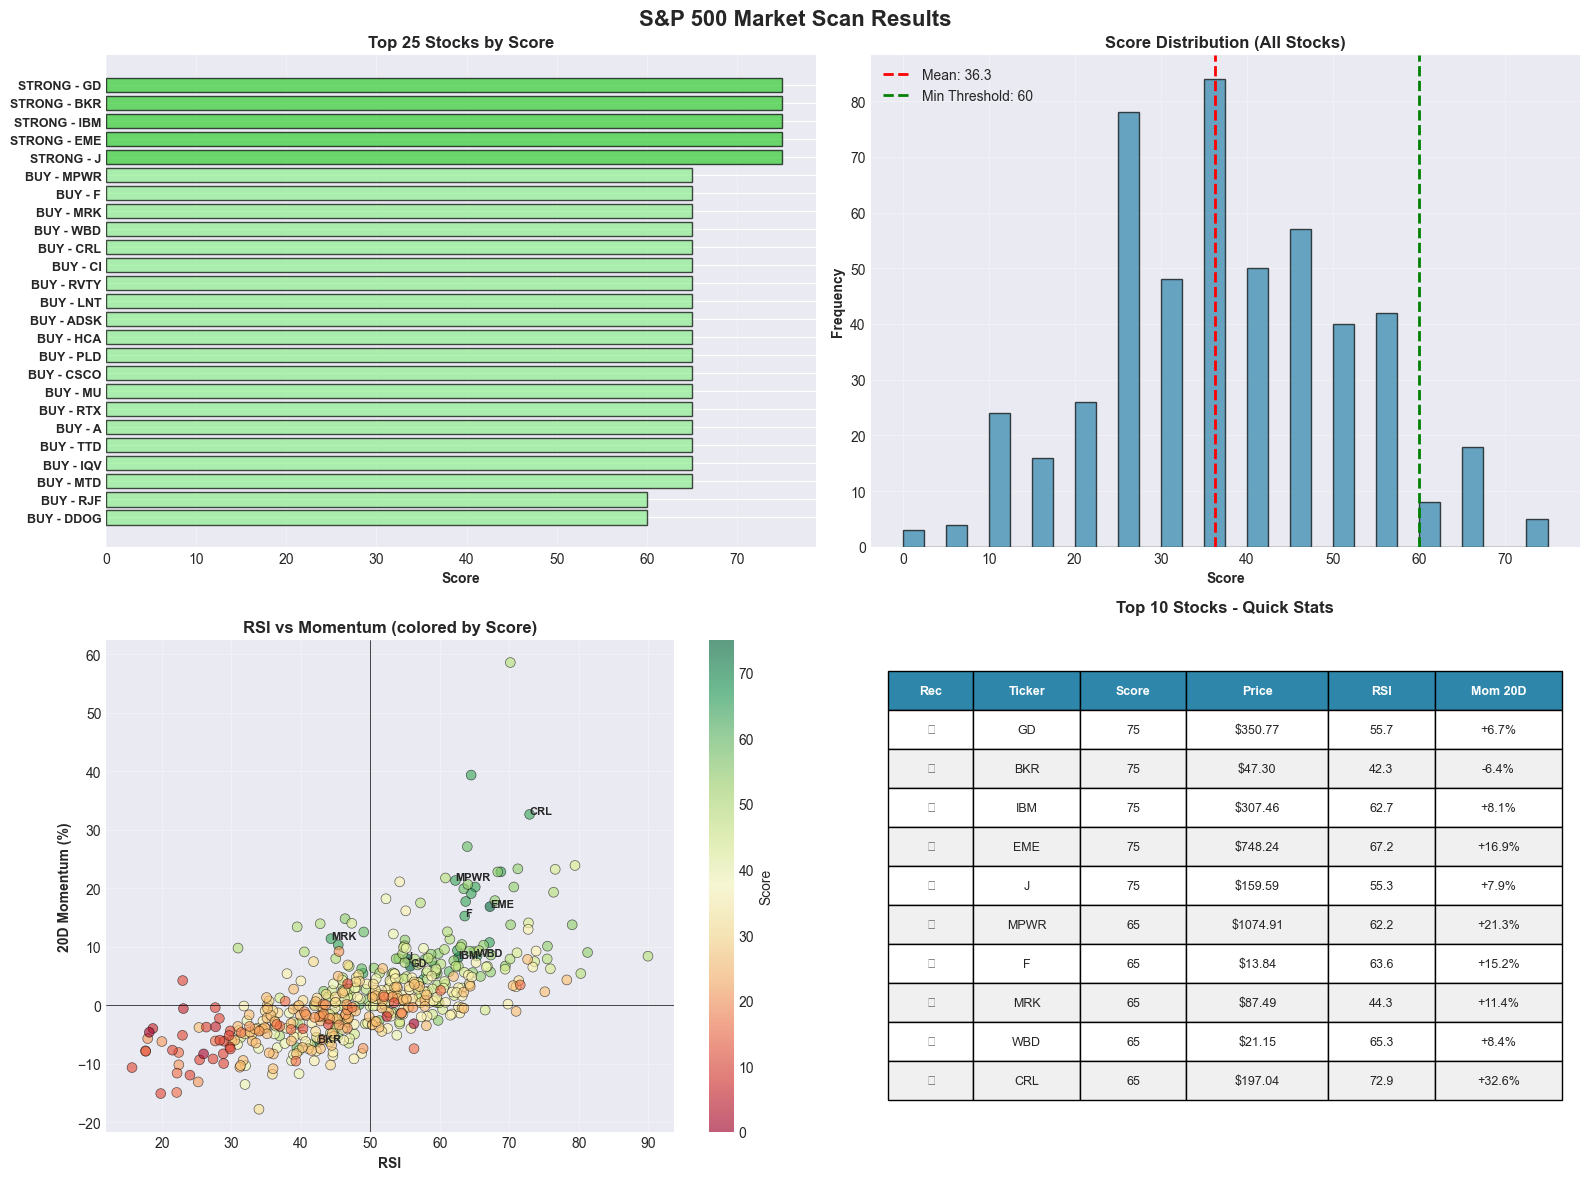


🎯 DEEP ANALYSIS - TOP 10 STOCKS
Selected stocks: GD, BKR, IBM, EME, J, MPWR, F, MRK, WBD, CRL


[1/10] ANALYZING GD

📥 Downloading 2y of data...
✅ Downloaded 502 days

📊 Calculating technical indicators...
✅ Indicators calculated

🧠 Creating ML features...
✅ Created 45 features

🎓 Training ML models...
ML Results:
  RF: Train=80.9%  Test=53.0% ⚠️
  GB: Train=96.6%  Test=53.9% ⚠️
  ⚠️ Warning: High overfitting detected (train-test gap: 42.7%)

🎯 Generating trading signals...
✅ 22 BUY | 19 SELL signals

💰 Running backtest...
✅ Backtest complete



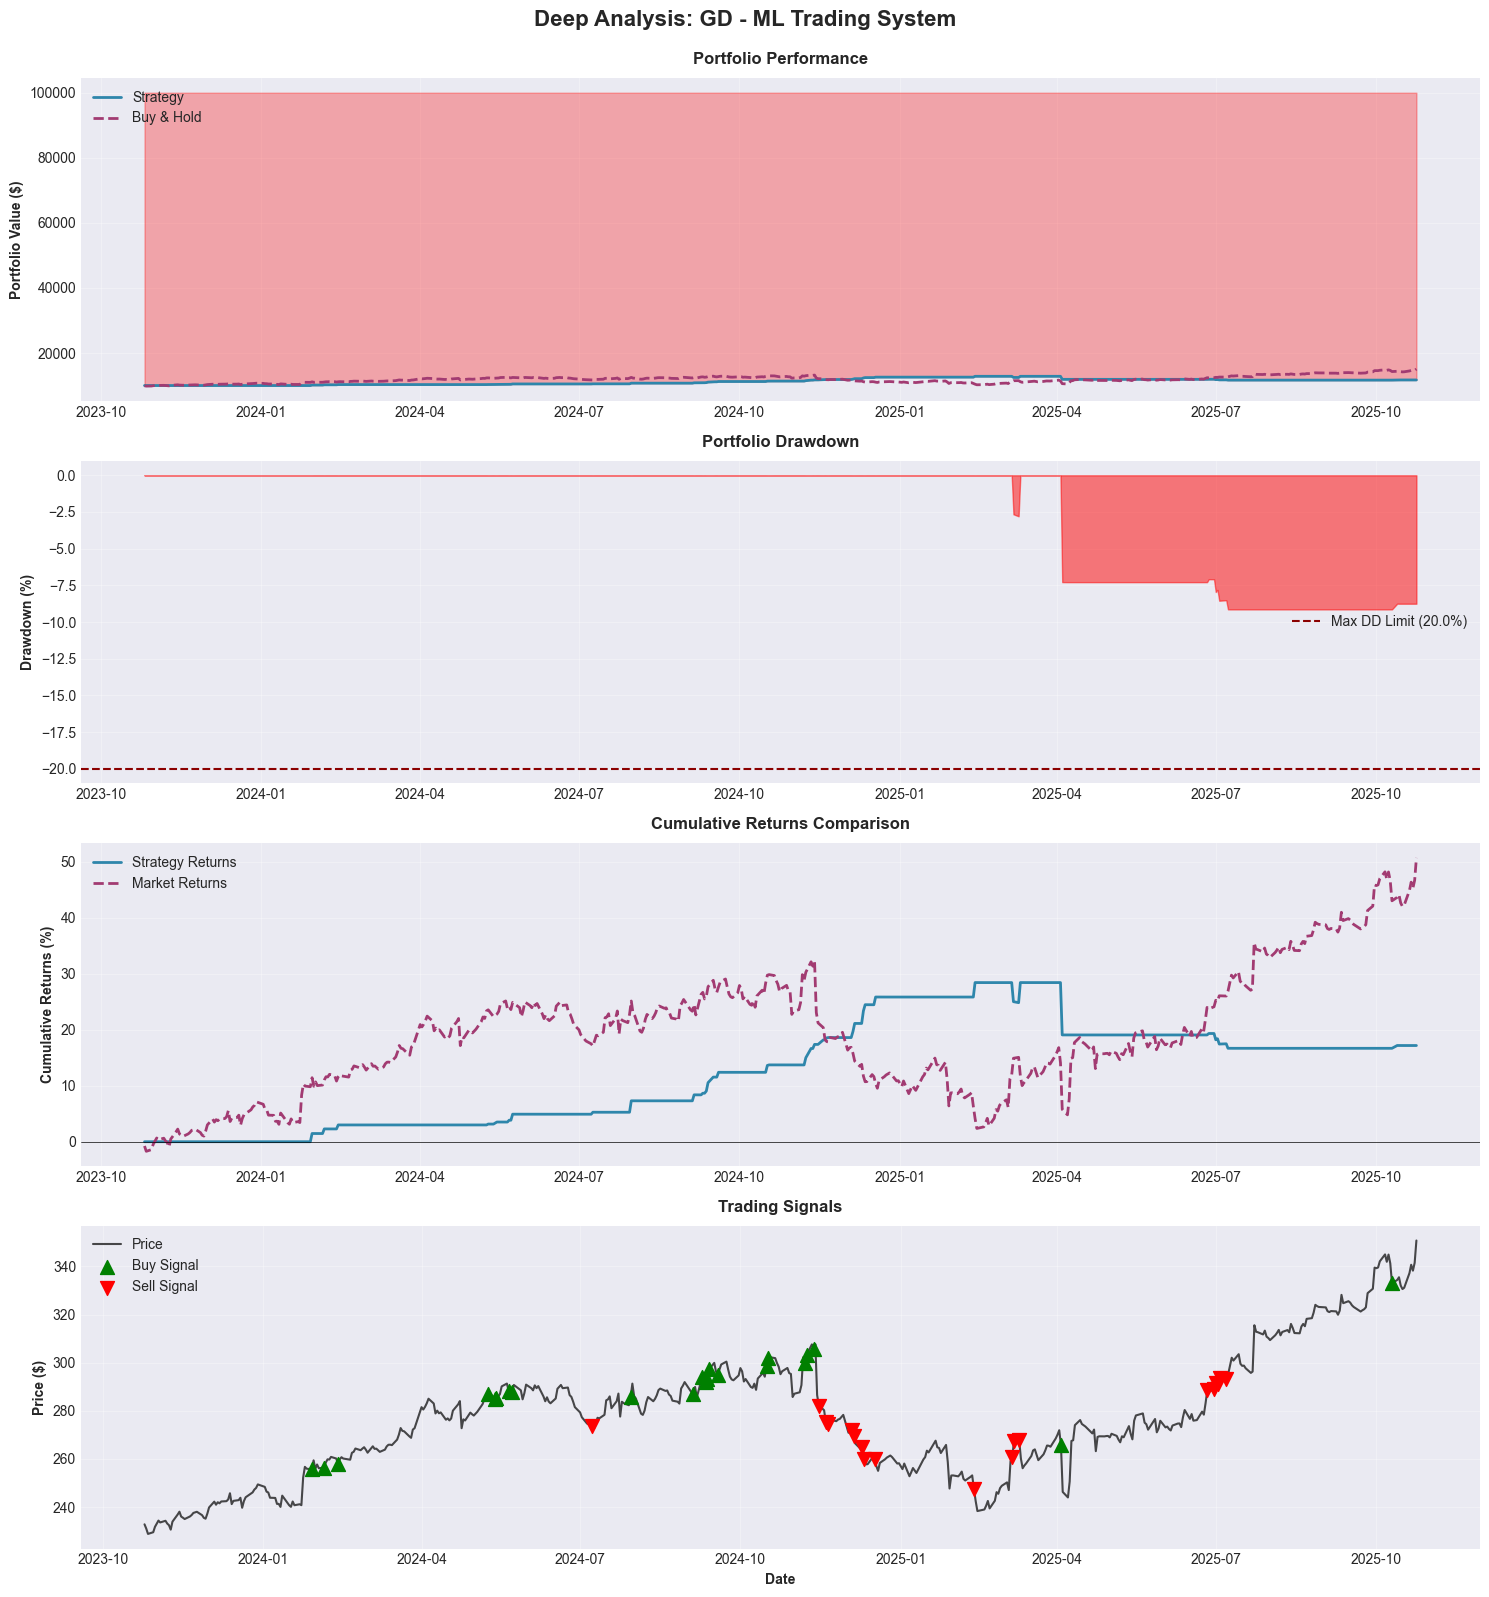


📊 BACKTEST RESULTS - GD
Total Return (%)........................        17.17%
Market Return (%).......................        50.66%
Alpha (%)...............................       -33.49%
Annualized Return (%)...................         8.28%
Volatility (%)..........................         7.11%
Sharpe Ratio............................         1.16
Max Drawdown (%)........................        -9.14%
Win Rate (%)............................         6.99%
Profit Factor...........................         2.30
Total Trades............................        27.00
Final Portfolio Value ($)............... $   11,717.18



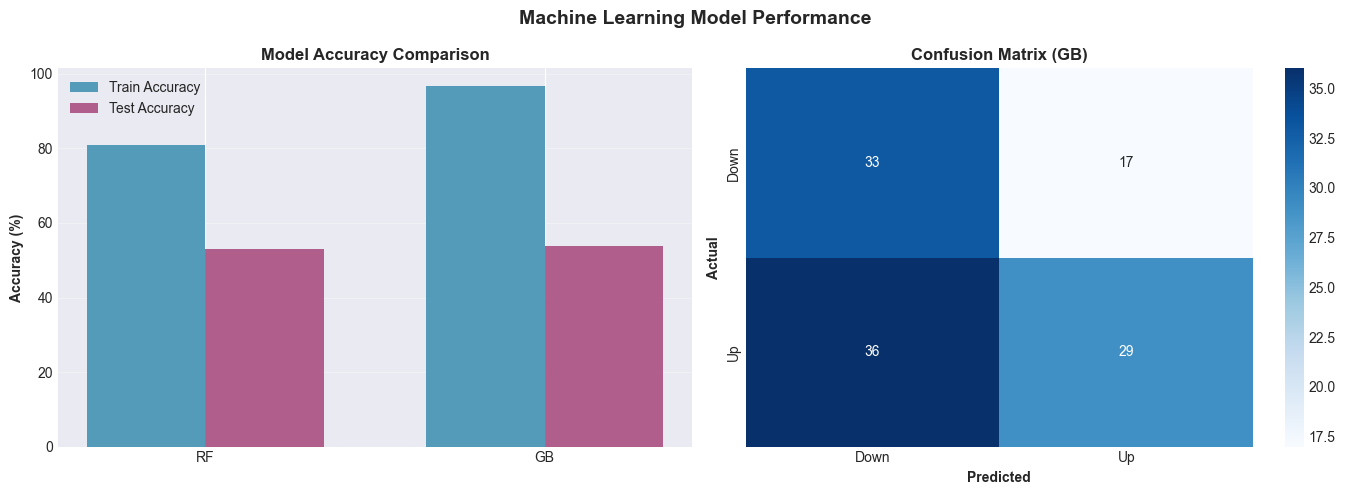


🤖 Best ML Model: GB
   Test Accuracy: 53.91%

[2/10] ANALYZING BKR

📥 Downloading 2y of data...
✅ Downloaded 502 days

📊 Calculating technical indicators...
✅ Indicators calculated

🧠 Creating ML features...
✅ Created 45 features

🎓 Training ML models...
ML Results:
  RF: Train=77.9%  Test=47.0% ❌
  GB: Train=96.3%  Test=52.2% ⚠️
  ⚠️ Warning: High overfitting detected (train-test gap: 44.1%)

🎯 Generating trading signals...
✅ 21 BUY | 9 SELL signals

💰 Running backtest...
✅ Backtest complete



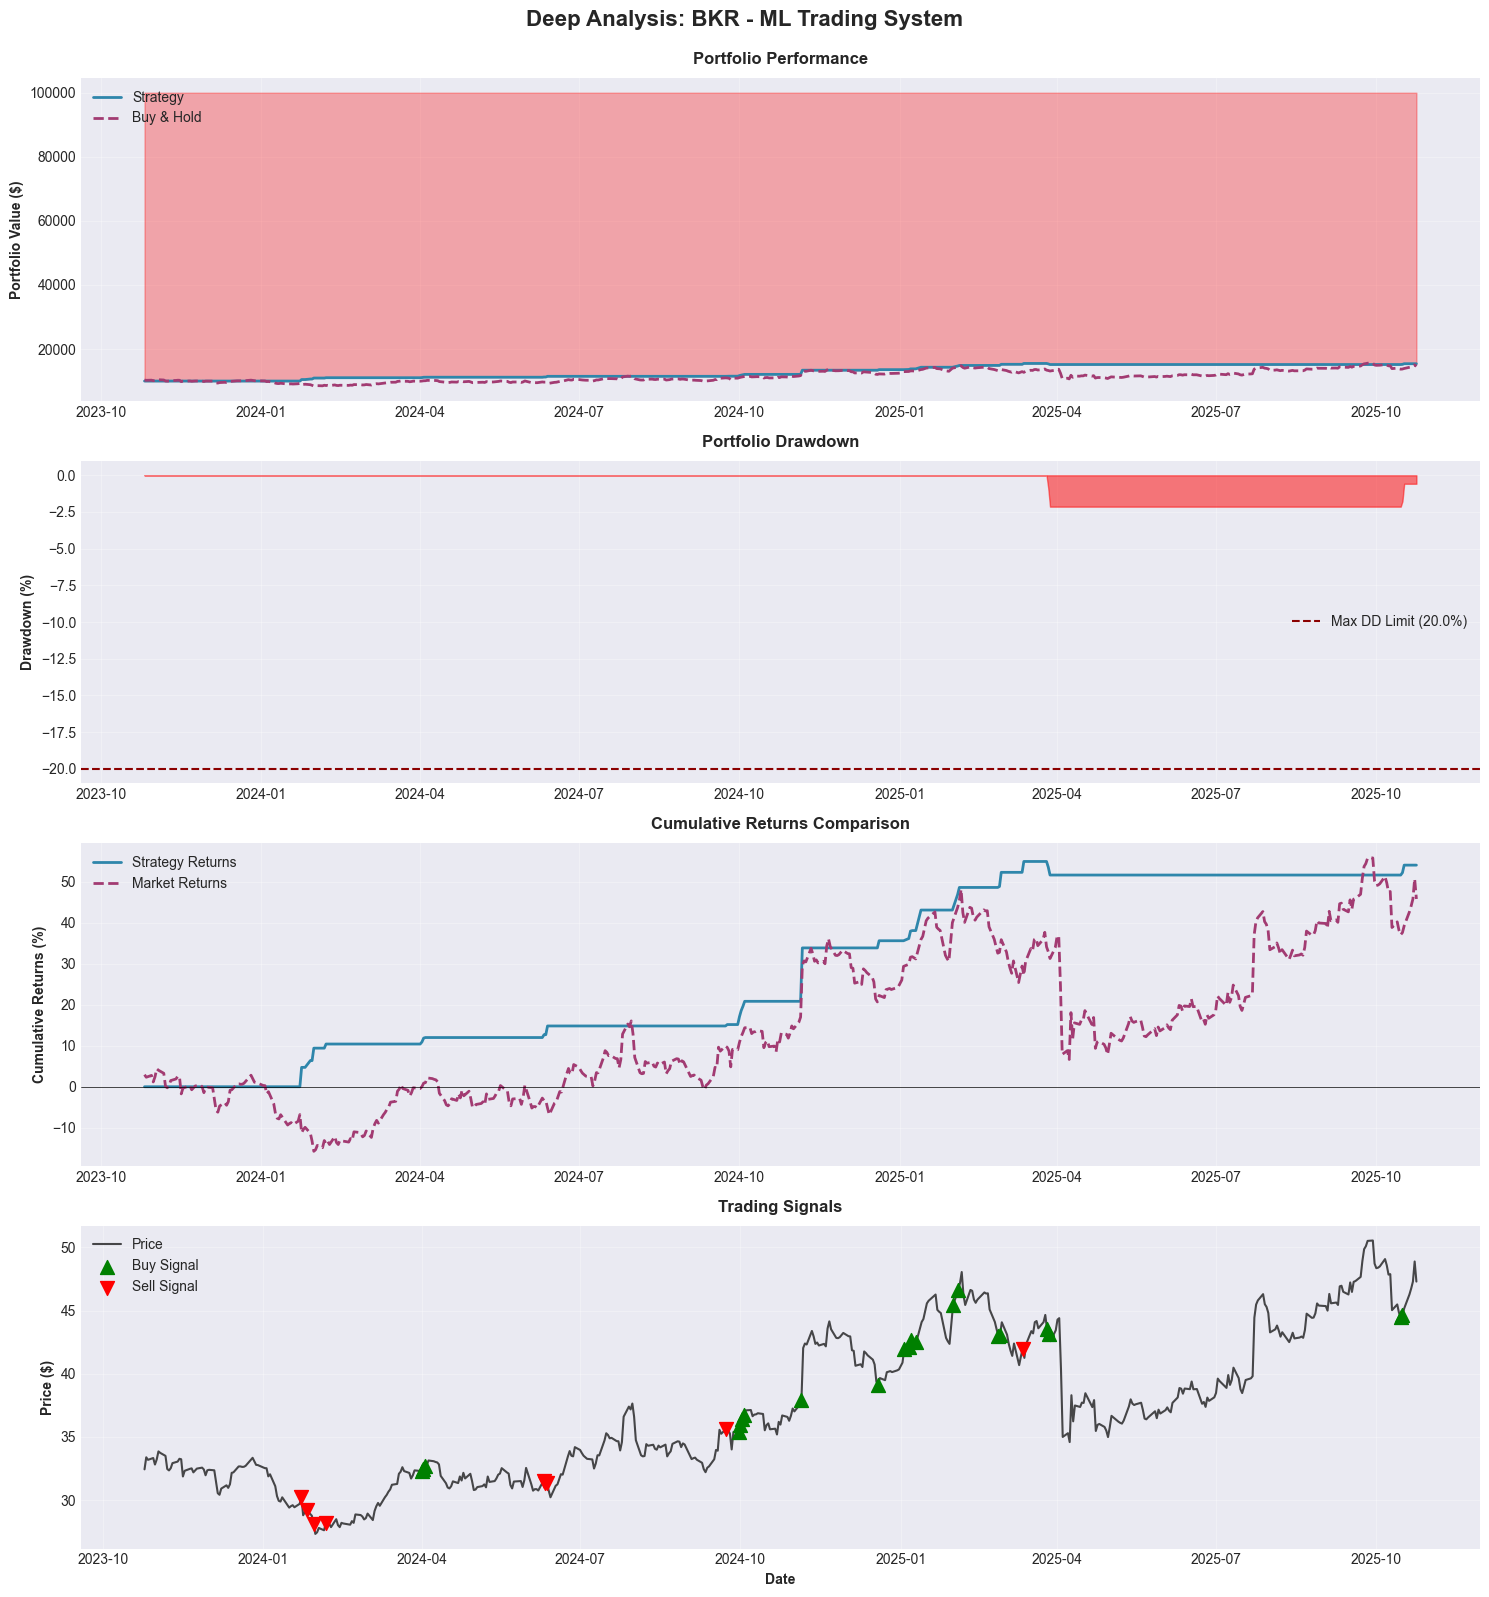


📊 BACKTEST RESULTS - BKR
Total Return (%)........................        54.07%
Market Return (%).......................        45.81%
Alpha (%)...............................         8.26%
Annualized Return (%)...................        24.23%
Volatility (%)..........................         9.91%
Sharpe Ratio............................         2.24
Max Drawdown (%)........................        -2.14%
Win Rate (%)............................         5.39%
Profit Factor...........................        21.48
Total Trades............................        17.00
Final Portfolio Value ($)............... $   15,406.70


[3/10] ANALYZING IBM

📥 Downloading 2y of data...
✅ Downloaded 502 days

📊 Calculating technical indicators...
✅ Indicators calculated

🧠 Creating ML features...
✅ Created 45 features

🎓 Training ML models...
ML Results:
  RF: Train=70.8%  Test=56.5% ✅
  GB: Train=98.1%  Test=53.0% ⚠️

🎯 Generating trading signals...
✅ 39 BUY | 2 SELL signals

💰 Running backtest...
✅ 

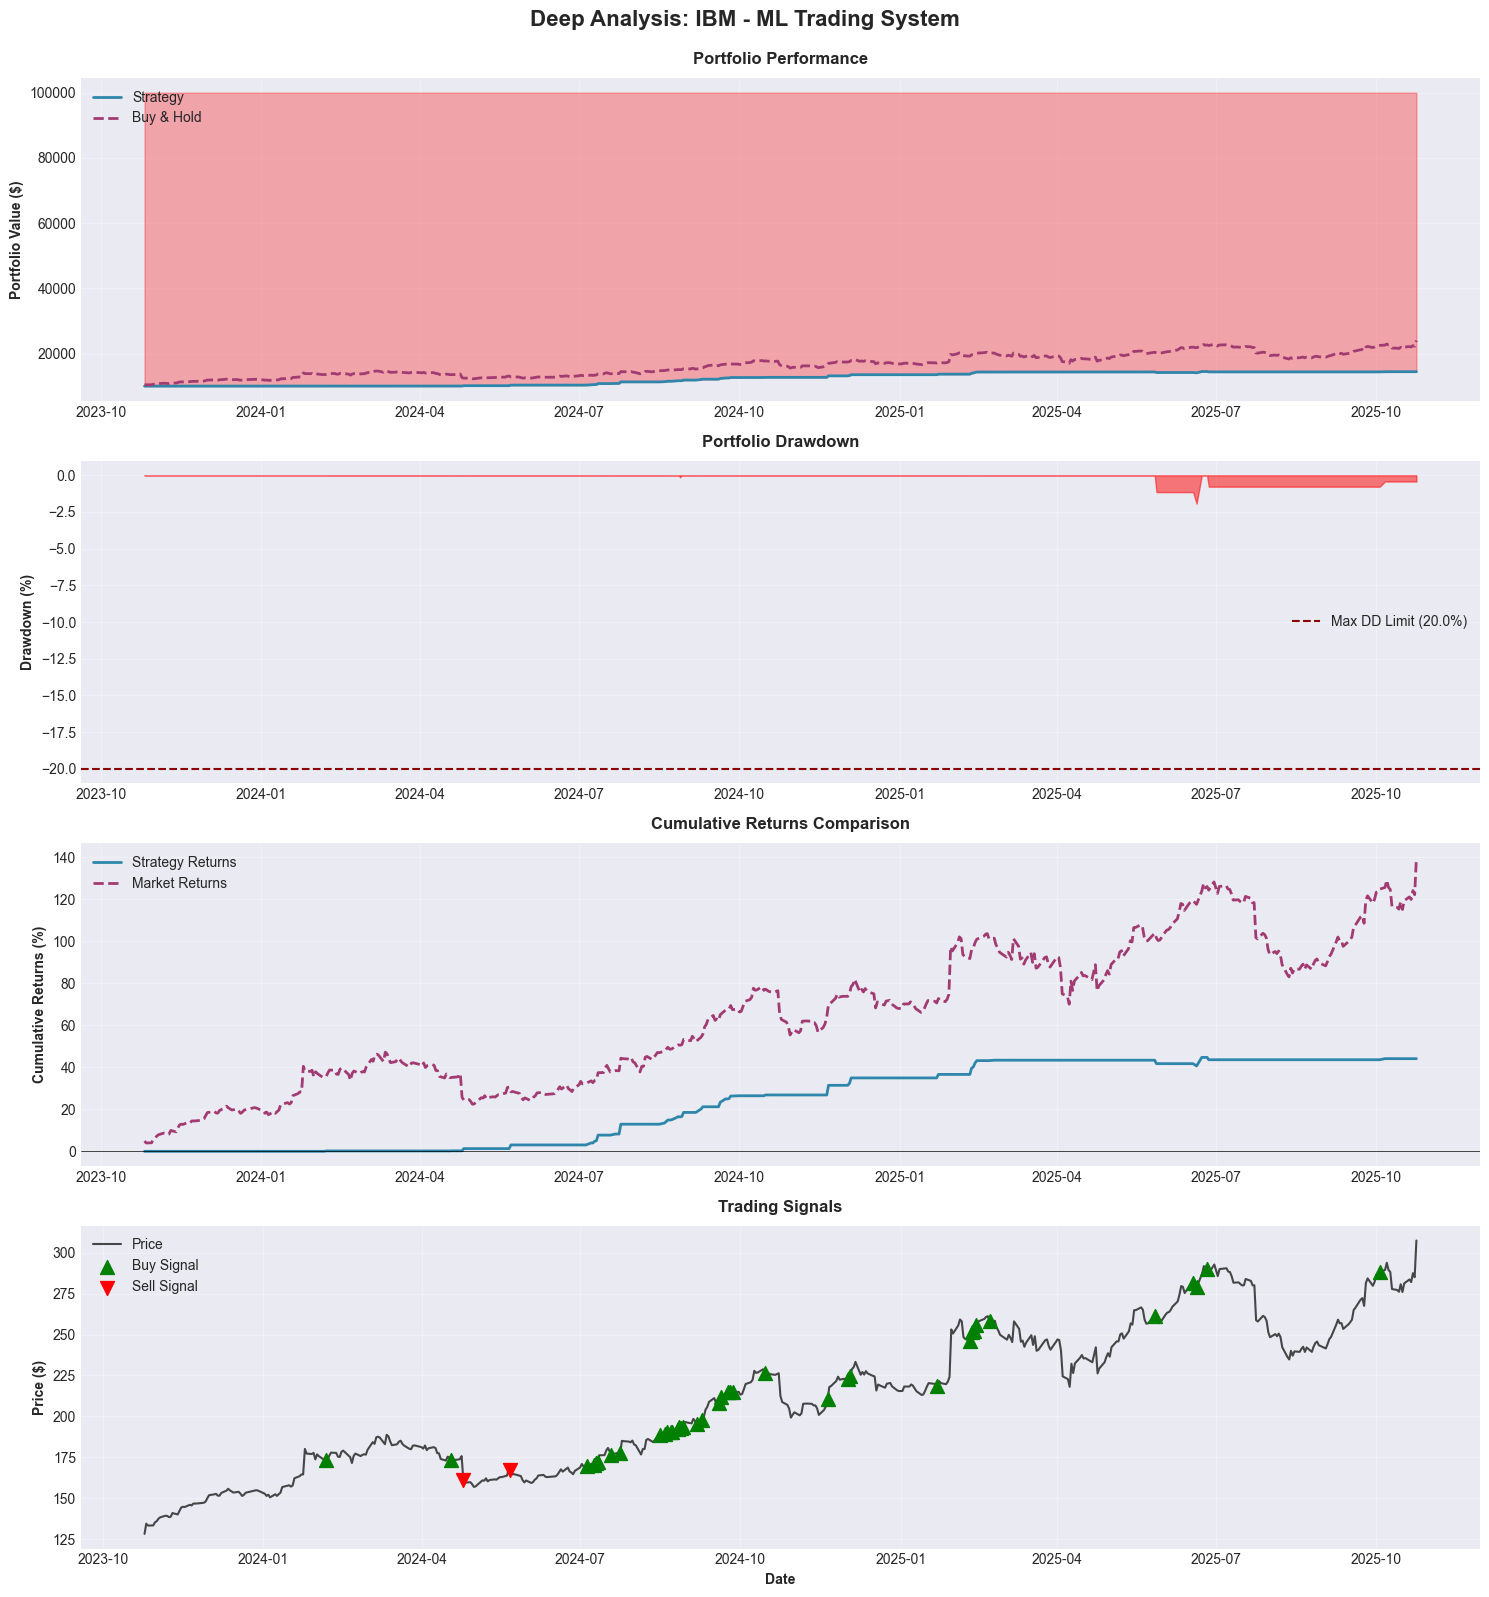


📊 BACKTEST RESULTS - IBM
Total Return (%)........................        44.14%
Market Return (%).......................       139.79%
Alpha (%)...............................       -95.65%
Annualized Return (%)...................        20.14%
Volatility (%)..........................         6.32%
Sharpe Ratio............................         2.94
Max Drawdown (%)........................        -1.93%
Win Rate (%)............................         7.39%
Profit Factor...........................        13.67
Total Trades............................        24.00
Final Portfolio Value ($)............... $   14,413.58


[4/10] ANALYZING EME

📥 Downloading 2y of data...
✅ Downloaded 502 days

📊 Calculating technical indicators...
✅ Indicators calculated

🧠 Creating ML features...
✅ Created 45 features

🎓 Training ML models...
ML Results:
  RF: Train=68.5%  Test=60.0% ✅
  GB: Train=94.0%  Test=54.8% ⚠️

🎯 Generating trading signals...
✅ 85 BUY | 9 SELL signals

💰 Running backtest...
✅ 

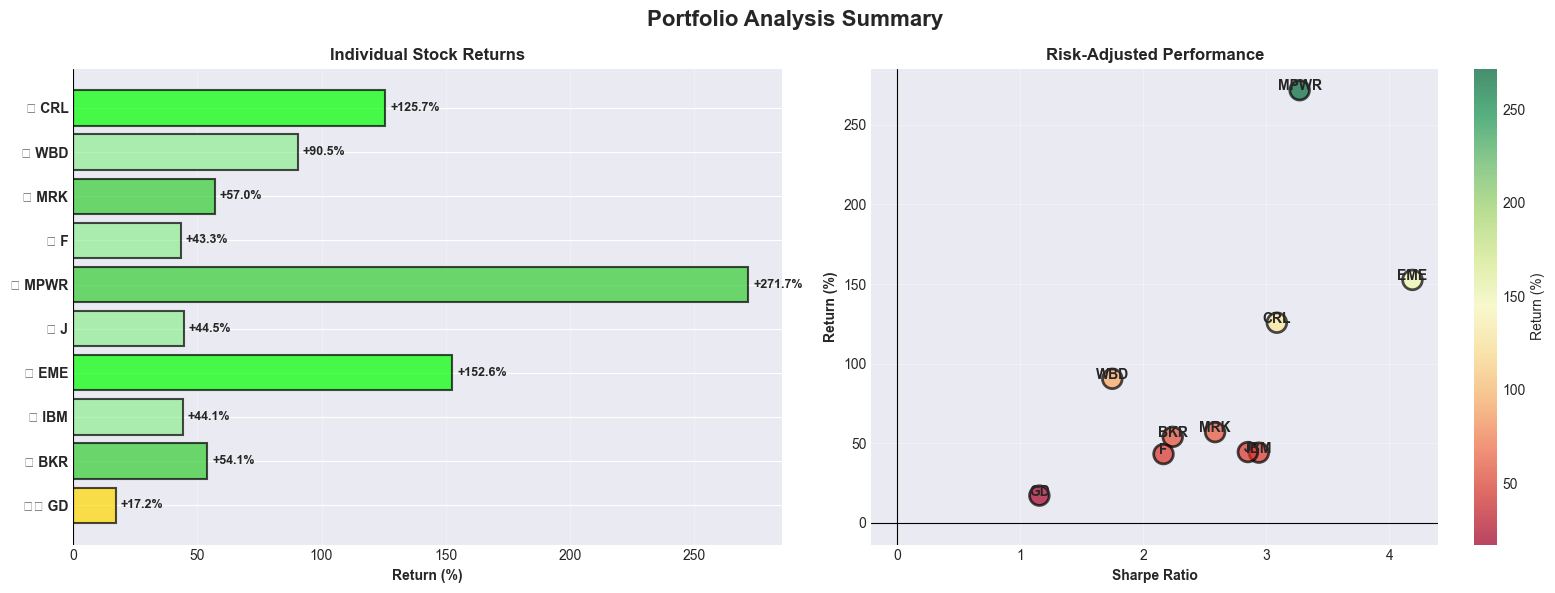


✅ ADVANCED ALGORITHMIC TRADING SYSTEM COMPLETE!

💡 SYSTEM CAPABILITIES:
   ✓ Scans entire S&P 500 (500+ stocks)
   ✓ Scores stocks using 40+ technical indicators
   ✓ Selects top candidates automatically
   ✓ Trains ensemble ML models (Random Forest + Gradient Boosting)
   ✓ Combines 4 trading strategies (ML, Mean Reversion, Momentum, Trend)
   ✓ Comprehensive backtesting with real costs
   ✓ Portfolio-level analysis and optimization

📝 RECOMMENDATIONS:
   • Review top-scoring stocks from the scan
   • Verify ML model accuracy (aim for >55% test accuracy)
   • Check Sharpe ratio (>1.0 is good, >2.0 is excellent)
   • Monitor maximum drawdown (<15% preferred)
   • Diversify across top 5-10 stocks
   • Consider win rate and profit factor together
   • Backtest on different time periods before live trading

🎯 ACTIONABLE RECOMMENDATIONS:
   1. PRIORITY ALLOCATION:
      • 40-50% in 🚀 EXPLOSIVE BUY (but max 2-3 positions)
      • 30-40% in 💎 STRONG BUY (2-3 positions)
      • 10-20% in 📈 B

In [12]:
# ==================== RUN THE COMPLETE SYSTEM =======================================
if __name__ == "__main__":
    try:
        print("⏱️  Estimated runtime: 5-15 minutes depending on number of stocks\n")
        output = run_advanced_trading_system()
        print("\n🎉 SYSTEM EXECUTION COMPLETE!")
        
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()

## 🎯 ACTIONABLE INVESTMENT RECOMMENDATIONS

### 1. PRIORITY ALLOCATION
- **40-50%** in 🚀 EXPLOSIVE BUY (max 2-3 positions)
- **30-40%** in 💎 STRONG BUY (2-3 positions)
- **10-20%** in 📈 BUY (1-2 positions for safety)

### 2. POSITION SIZING
- Never exceed **15-20%** in a single stock
- Start with smaller positions (5-10%) and scale up
- Use dollar-cost averaging over 2-4 weeks

### 3. RISK MANAGEMENT
- Avoid stocks with >15% max drawdown unless returns >200%
- Implement 5-7% stop losses (already in backtest)
- Scale out of winners: 
  - Sell 25% at 50% gain
  - Sell 25% at 100% gain
  - Let rest run with trailing stop

### 4. ENTRY STRATEGY
- Don't buy all at once - average in over 2-4 weeks
- Wait for RSI < 60 on explosive momentum stocks
- Use limit orders 1-2% below current price
- Buy on pullbacks to 20-day moving average

### 5. MONITORING SCHEDULE
- **Daily:** Check for stop-loss triggers
- **Weekly:** Review if signals still valid
- **Monthly:** Re-run full scan to update rankings
- **Quarterly:** Rebalance based on performance

### 6. DIVERSIFICATION GUIDELINES
- Aim for **7-10 stocks** from different sectors
- Don't hold more than **3 stocks** from same sector
- Include mix of tech, finance, healthcare, consumer

### 7. EXIT SIGNALS
- Exit if ML accuracy drops below 45% for 2+ months
- Exit if drawdown exceeds your risk tolerance
- Exit if fundamentals deteriorate (earnings misses)
- Exit if stock drops below recommendation score threshold

### 8. PERFORMANCE EXPECTATIONS
- **Realistic Annual Returns:** 15-30% (excellent performance)
- **Sharpe Ratio Target:** >1.5 (good risk-adjusted returns)
- **Win Rate:** 10-15% is NORMAL for momentum strategies
- **Max Drawdown:** Expect 10-20% corrections
- **Exceptional Returns (>500%):** RARE - don't expect regularly

### 9. WARNING SIGNS TO EXIT
- ML model accuracy deteriorates significantly
- Sharpe ratio turns negative for 3+ months
- Drawdown exceeds 25%
- Market conditions change dramatically (recession)

### 10. TAX CONSIDERATIONS
- Hold positions >1 year for long-term capital gains
- Keep detailed records of all trades
- Consider tax-loss harvesting opportunities
- Consult with tax professional

---

## ⚠️ FINAL DISCLAIMER

This system is for **EDUCATIONAL PURPOSES ONLY**:

- Backtested performance ≠ future results
- Markets are unpredictable and risky
- Only invest money you can afford to lose
- Always do your own due diligence
- Consider consulting a financial advisor
- Past patterns may not repeat

**The creators of this system assume NO responsibility for financial losses. DYOR before investing.**

---

## 📚 Further Learning

### Recommended Resources:
1. **Books:**
   - "Advances in Financial Machine Learning" by Marcos López de Prado
   - "Algorithmic Trading" by Ernest P. Chan
   - "Machine Trading" by Ernest P. Chan

2. **Online Courses:**
   - Coursera: Machine Learning for Trading
   - Udacity: AI for Trading Nanodegree

3. **Research Papers:**
   - "The Cross-Section of Expected Stock Returns" (Fama-French)
   - "Momentum Strategies" (Jegadeesh and Titman)

4. **Python Libraries:**
   - QuantLib for quantitative finance
   - Backtrader for backtesting
   - TA-Lib for technical analysis

---

## 🤝 Contributing & Feedback

If you found this project helpful:
- ⭐ Star the repository
- 🐛 Report issues or bugs
- 💡 Suggest improvements
- 🔄 Share with others learning algo trading

--- 
**Author:** Md Fayaz Ahamed, Ph.D.

🚀 **Good luck with your trading!** Remember:  
💎 **Discipline > Emotion**  
📊 **Strategy > Luck**  
🛡️ **Risk Management > Everything**

